# Exploratory Analysis of Water Quality Data

This document includes Python code and results of the exploratory analysis of water quality data in the SEACAR Pilot project.

In [207]:
import matplotlib.pyplot as plt
import numpy      as np
import pandas     as pd
import geopandas  as gpd
import contextily as cx

## 1. Data preprocessing
Read the csv file of data.

In [208]:
df = pd.read_csv("../OEAT_Discrete-2022-Aug-31.csv")

C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (6,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Select five managed areas and five parameters. Select only columns that are needed for the analysis. Convert the SampleDate from string to datetime object.

In [209]:
df2 = df.loc[df["ManagedAreaName"].isin(["Guana Tolomato Matanzas National Estuarine Research Reserve",
                            "Biscayne Bay Aquatic Preserve",
                            "Estero Bay Aquatic Preserve",
                            "Gasparilla Sound-Charlotte Harbor Aquatic Preserve",
                            "Big Bend Seagrasses Aquatic Preserve"])]
df2 = df2[['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
           'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']]
df2 = df2.loc[df2["ParameterName"].isin(["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"])]
df2["timestamp"]=  pd.to_datetime(df2['SampleDate'])
df2.head()

RowID     ParameterName ParameterUnits ProgramLocationID ActivityType  \
22     23  Dissolved Oxygen           mg/L        FLW06-0041        Field   
23     24  Dissolved Oxygen           mg/L         FL00-0020        Field   
24     25  Dissolved Oxygen           mg/L         FL00-0011        Field   
25     26  Dissolved Oxygen           mg/L        FLW05-0020        Field   
26     27  Dissolved Oxygen           mg/L         FL01-0014        Field   

                                      ManagedAreaName  SampleDate  Year  \
22  Gasparilla Sound-Charlotte Harbor Aquatic Pres...  2006-12-31  2006   
23  Gasparilla Sound-Charlotte Harbor Aquatic Pres...  2000-12-31  2000   
24               Big Bend Seagrasses Aquatic Preserve  2000-12-31  2000   
25               Big Bend Seagrasses Aquatic Preserve  2005-12-31  2005   
26  Gasparilla Sound-Charlotte Harbor Aquatic Pres...  2001-12-31  2001   

    Month  ResultValue ValueQualifier  Latitude_DD  Longitude_DD  timestamp  
22     12          5.5            NaN     26.83697     -82.09640 2006-12-31  
23     12          5.0            NaN     26.75800     -82.08850 2000-12-31  
24     12          9.6            NaN     29.15600     -83.05780 2000-12-31  
25     12          6.7            NaN     30.07050     -84.10702 2005-12-31  
26     12          5.0            NaN     26.75900     -82.07900 2001-12-31

In [210]:
size1 = df2.shape[0]

Remove outliers in **total nitrogen** (>100) and **turbidity** (>20).

In [211]:
df2.shape

(656747, 14)

In [212]:
df2[(df2['ParameterName'] == 'Total Nitrogen') & 
    (df2['ResultValue'] > 9)]

RowID   ParameterName ParameterUnits        ProgramLocationID  \
891057    891058  Total Nitrogen           mg/L       STORET_CHNEPTMR-41   
1582916  1582917  Total Nitrogen           mg/L  STORET_21FLEECO_48-10GR   
1702401  1702402  Total Nitrogen           mg/L    WIN_21FLGTM_GTMGL1NUT   
1702886  1702887  Total Nitrogen           mg/L            STORET_CHV006   

        ActivityType                                    ManagedAreaName  \
891057        Sample  Gasparilla Sound-Charlotte Harbor Aquatic Pres...   
1582916       Sample                        Estero Bay Aquatic Preserve   
1702401       Sample  Guana Tolomato Matanzas National Estuarine Res...   
1702886       Sample  Gasparilla Sound-Charlotte Harbor Aquatic Pres...   

         SampleDate  Year  Month  ResultValue ValueQualifier  Latitude_DD  \
891057   2005-04-12  2005      4       10.100              !    26.925631   
1582916  1996-07-22  1996      7        9.430            NaN    26.368195   
1702401  2021-06-07  2021      6       12.602            NaN    30.150400   
1702886  2009-07-06  2009      7      302.300            NaN    26.934722   

         Longitude_DD  timestamp  
891057     -82.175001 2005-04-12  
1582916    -81.820382 1996-07-22  
1702401    -81.360400 2021-06-07  
1702886    -82.056900 2009-07-06

In [215]:
# Remove total nitrogen outliers (>100)
df2.drop(df2[(df2['ParameterName'] == 'Total Nitrogen') & 
    (df2['ResultValue'] > 100)].index,inplace=True)

# Remove a single measurement in 1996-07-22 (RowID: 1582917)
df2.drop(df2[df2['RowID'] == 1582917].index, inplace=True)

# Remove turbidity outliers (>25)
df2.drop(df2[(df2['ParameterName'] == 'Turbidity') & 
    (df2['ResultValue'] > 25)].index, inplace=True)

# Remove Secchi Depth before 1995 (117 records)
df2.drop(df2[(df2['ParameterName'] == 'Secchi Depth') & 
    (df2['Year'] < 1995)].index, inplace=True)

## 2. Exploratory Analysis
Create lists of water quality parameters, lists of five managed areas and list of statistics to be calculated.

In [216]:
listPara = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
listArea = ["Guana Tolomato Matanzas National Estuarine Research Reserve",
                            "Biscayne Bay Aquatic Preserve",
                            "Estero Bay Aquatic Preserve",
                            "Gasparilla Sound-Charlotte Harbor Aquatic Preserve",
                            "Big Bend Seagrasses Aquatic Preserve" ]
listValue = ["count", "mean","max","min","std"]

Calculate each parameters' Count, Max, Min, Mean, and STD of each areas in weekly, monthly, quarterly and yearly intervals.

In [217]:
weekly_count     = df2.groupby(["ParameterName","ManagedAreaName",pd.Grouper(key="timestamp",freq="W")])[
    "ResultValue"].agg(["count","max","min","mean","std"]).sort_values("timestamp").reset_index()
monthly_count    = df2.groupby(["ParameterName","ManagedAreaName",pd.Grouper(key="timestamp",freq="M")])[
    "ResultValue"].agg(["count","max","min","mean","std"]).sort_values("timestamp").reset_index()
quarterly_count  = df2.groupby(["ParameterName","ManagedAreaName",pd.Grouper(key="timestamp",freq="Q")])[
    "ResultValue"].agg(["count","max","min","mean","std"]).sort_values("timestamp").reset_index()
yearly_count     = df2.groupby(["ParameterName","ManagedAreaName",pd.Grouper(key="timestamp",freq="Y")])[
    "ResultValue"].agg(["count","max","min","mean","std"]).sort_values("timestamp").reset_index()

### 2.1 Weekly Count
Create line charts for sample **counts** in **weekly** intervals. The weekly results show that the number of samples fluctuate from week to week. Some areas have less than 5 data samples in some weeks. Spatial interpolation from the few samples may have high and fluctuating uncertainty. **Thus, spatial interpolation in weekly intervals is NOT practical**. 

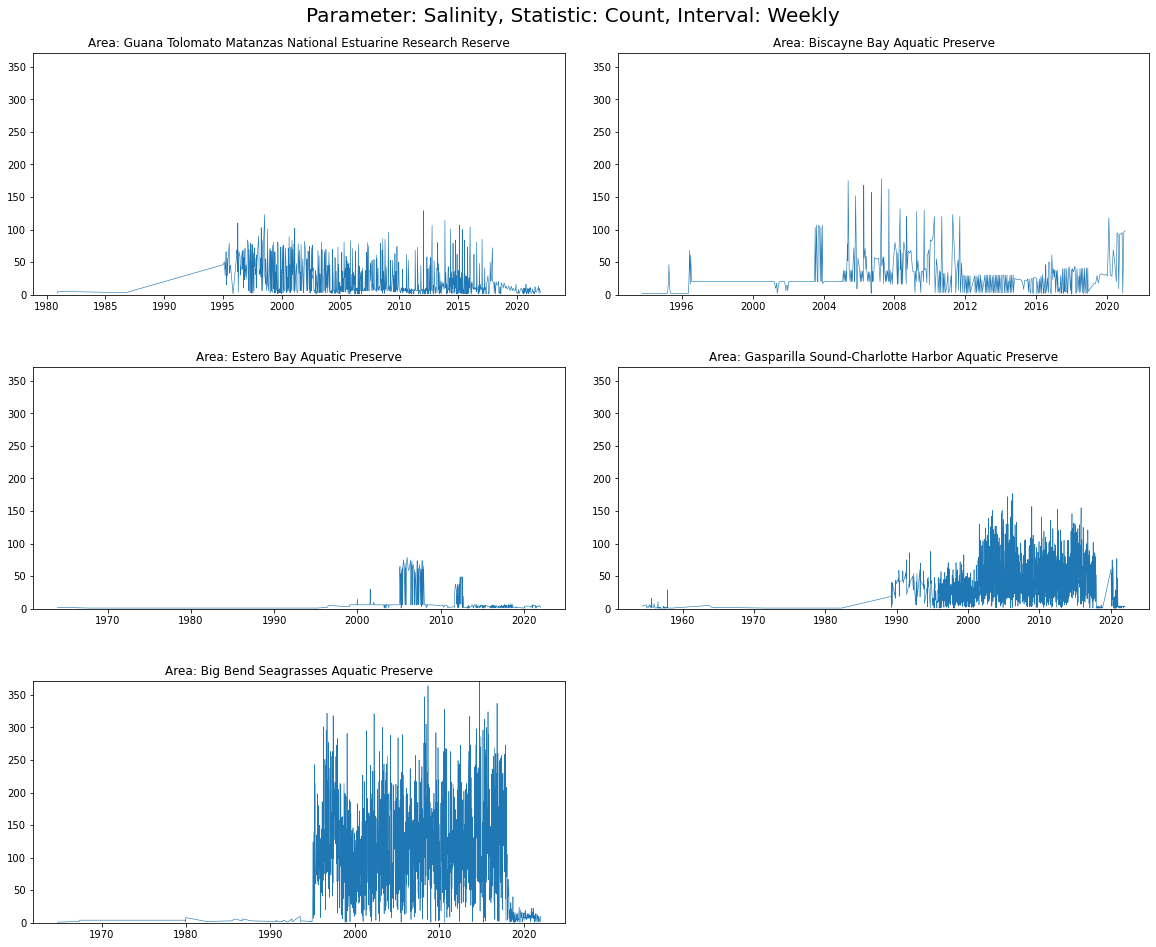

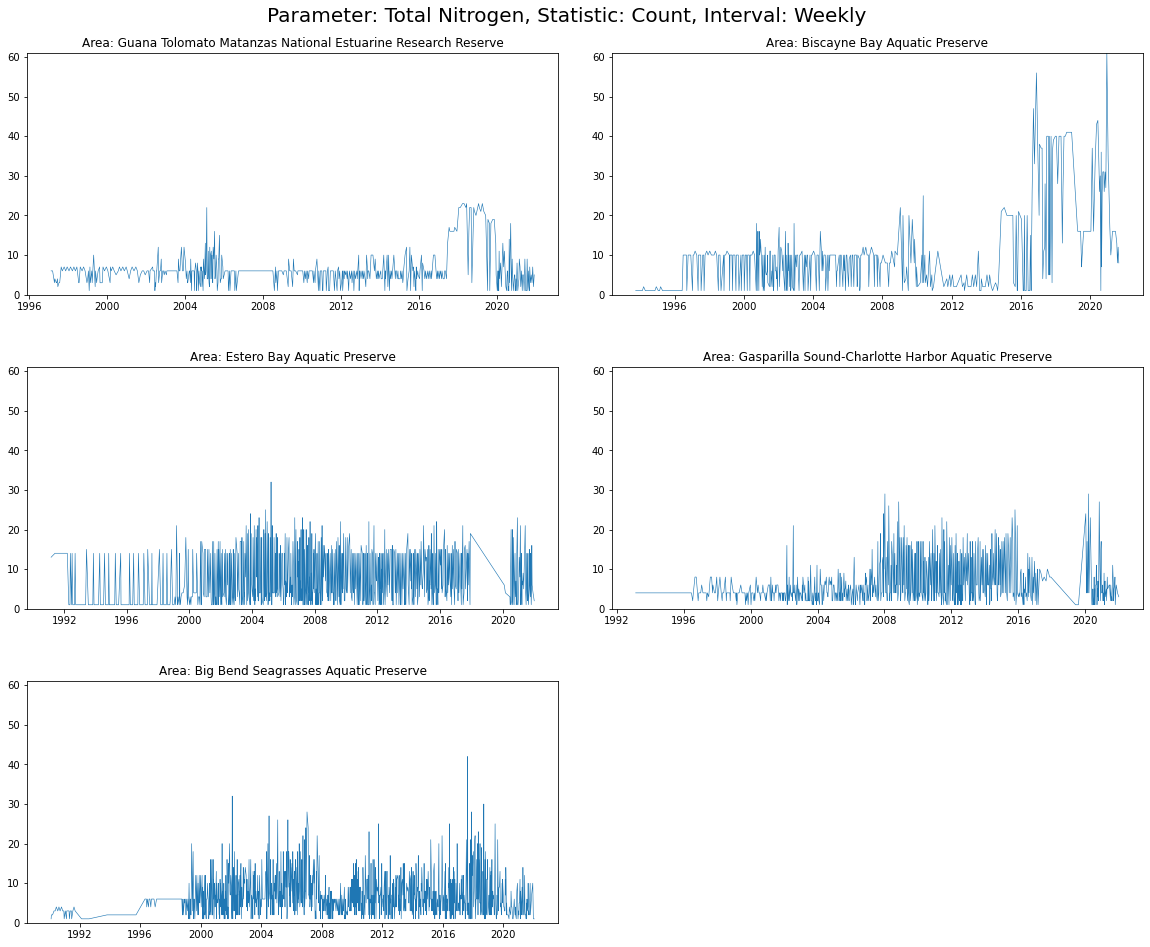

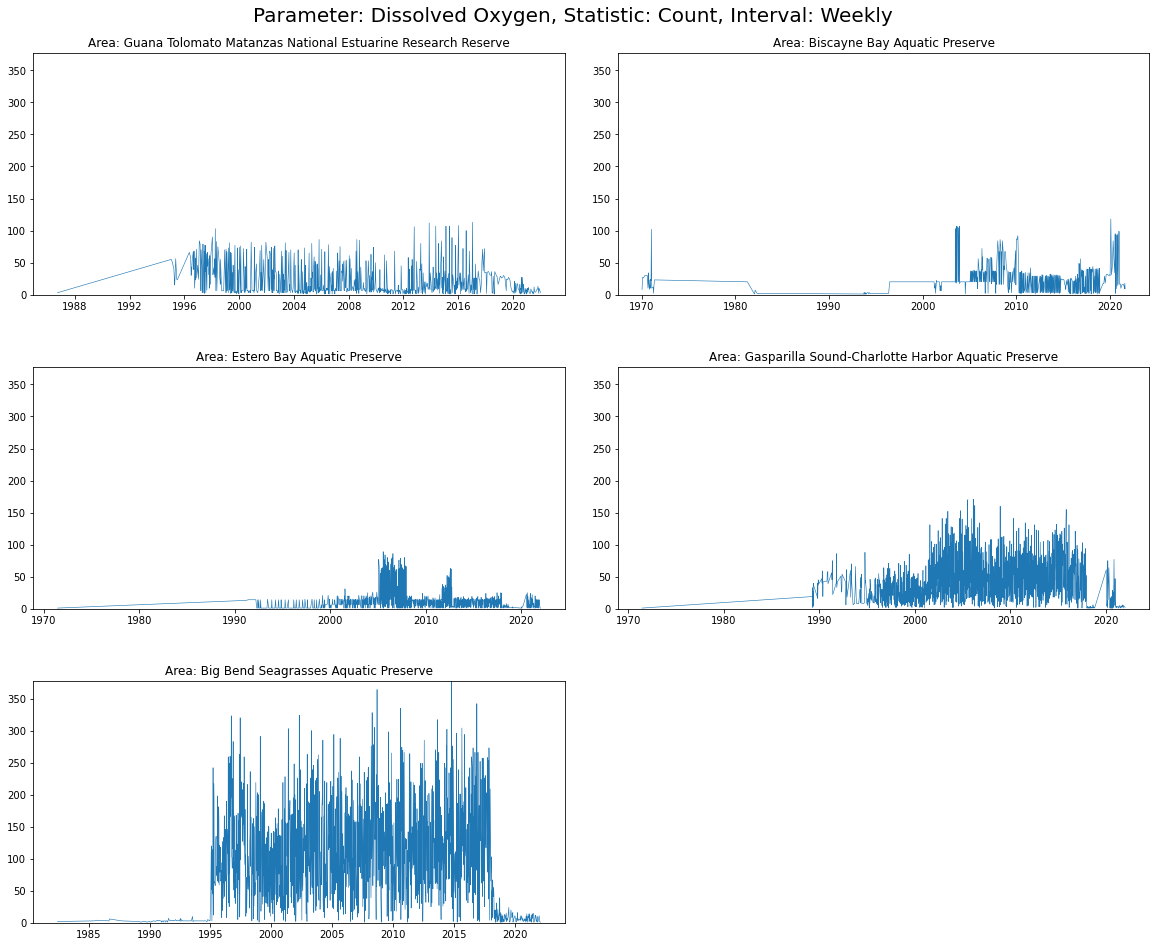

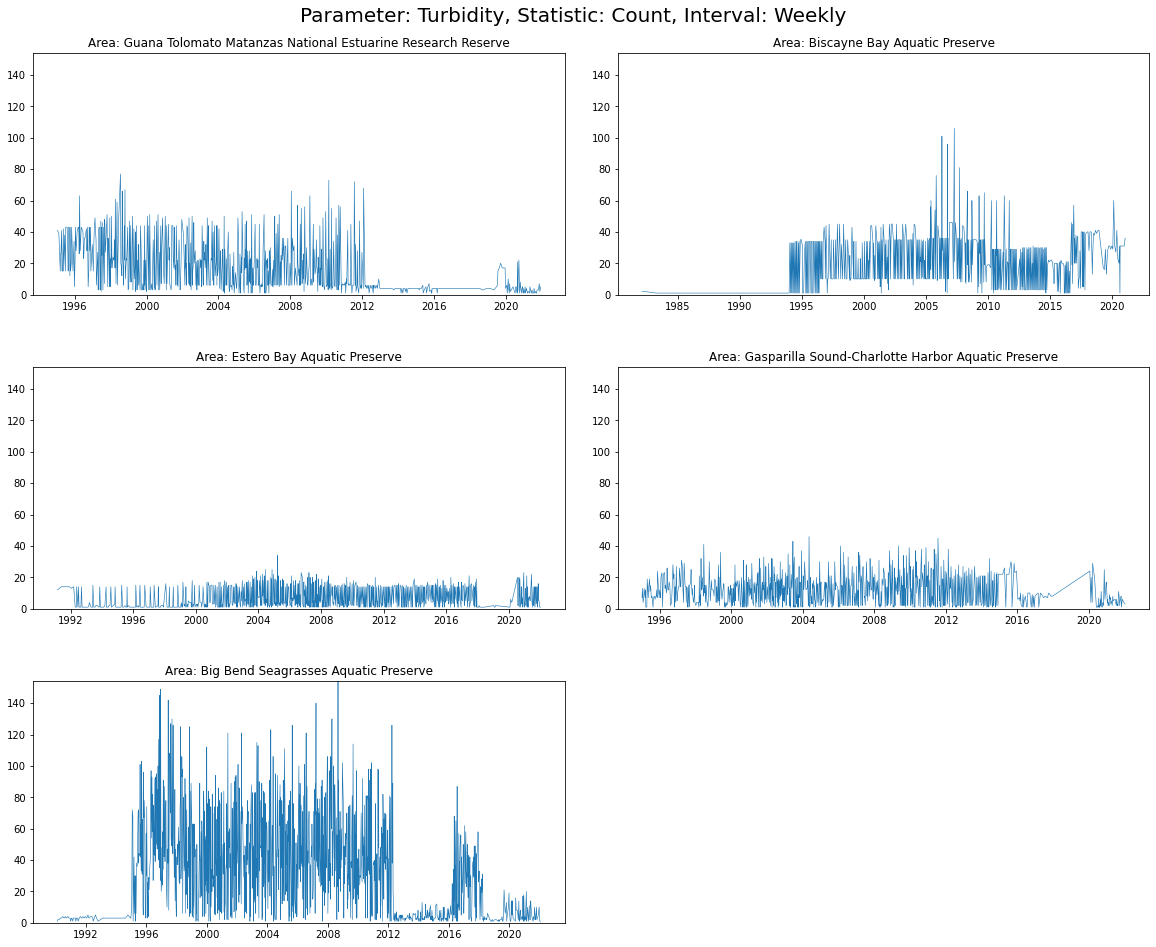

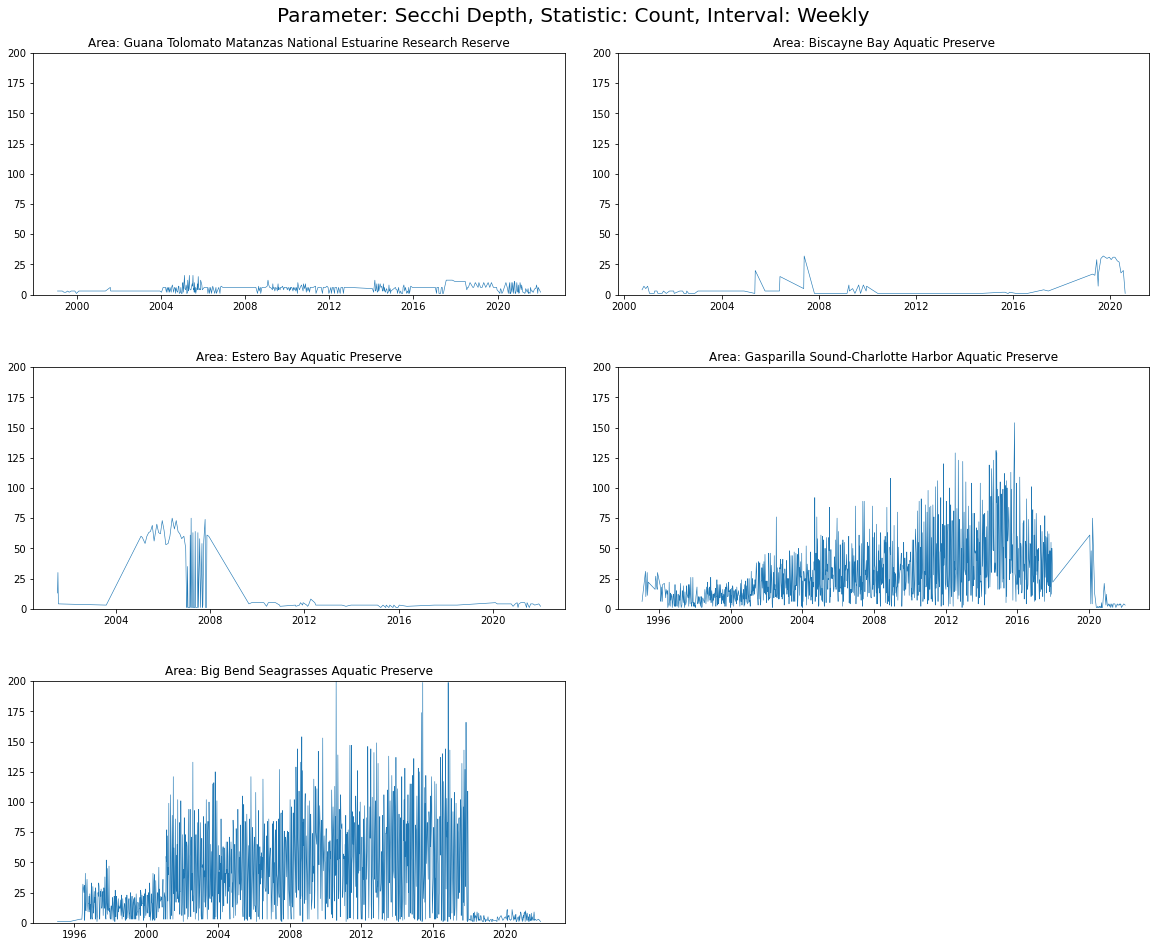

In [218]:
plt.rcParams['figure.figsize'] = [20, 16]
#for value in listValue:
value = listValue[0]
for para in listPara:
    fig = plt.figure()
    # Create the main title
    plt.suptitle("Parameter: " + para + ", Statistic: " + value.capitalize() + ", Interval: Weekly", fontsize = 20, y = 0.92)
    # Calculate the upper limit of y axis
    up_lim = weekly_count[(weekly_count["ParameterName"] == para)]['count'].max()
    for i in range(len(listArea)):
        dfNew = weekly_count[(weekly_count["ParameterName"] == para)&(weekly_count["ManagedAreaName"]== listArea[i])]
        ax = fig.add_subplot(3,2,i+1,title=str('Area: '+ listArea[i]))
        ax.plot(dfNew["timestamp"],dfNew[str(value)],linewidth=0.6)
        ax.set_ylim([0,up_lim])
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

### 2.2 Monthly Count

Create line charts for sample **counts** in monthly intervals. These line charts shows sampling activity in different time periods.

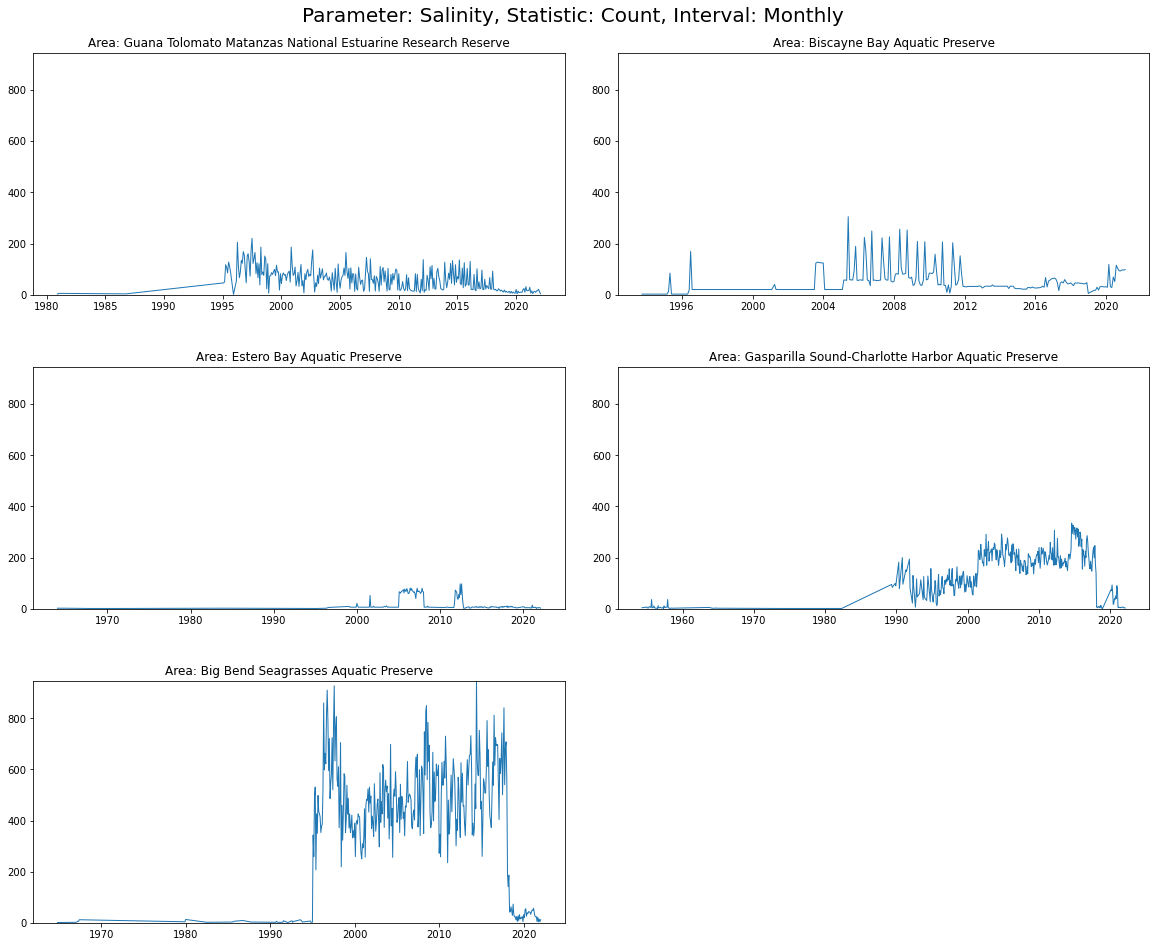

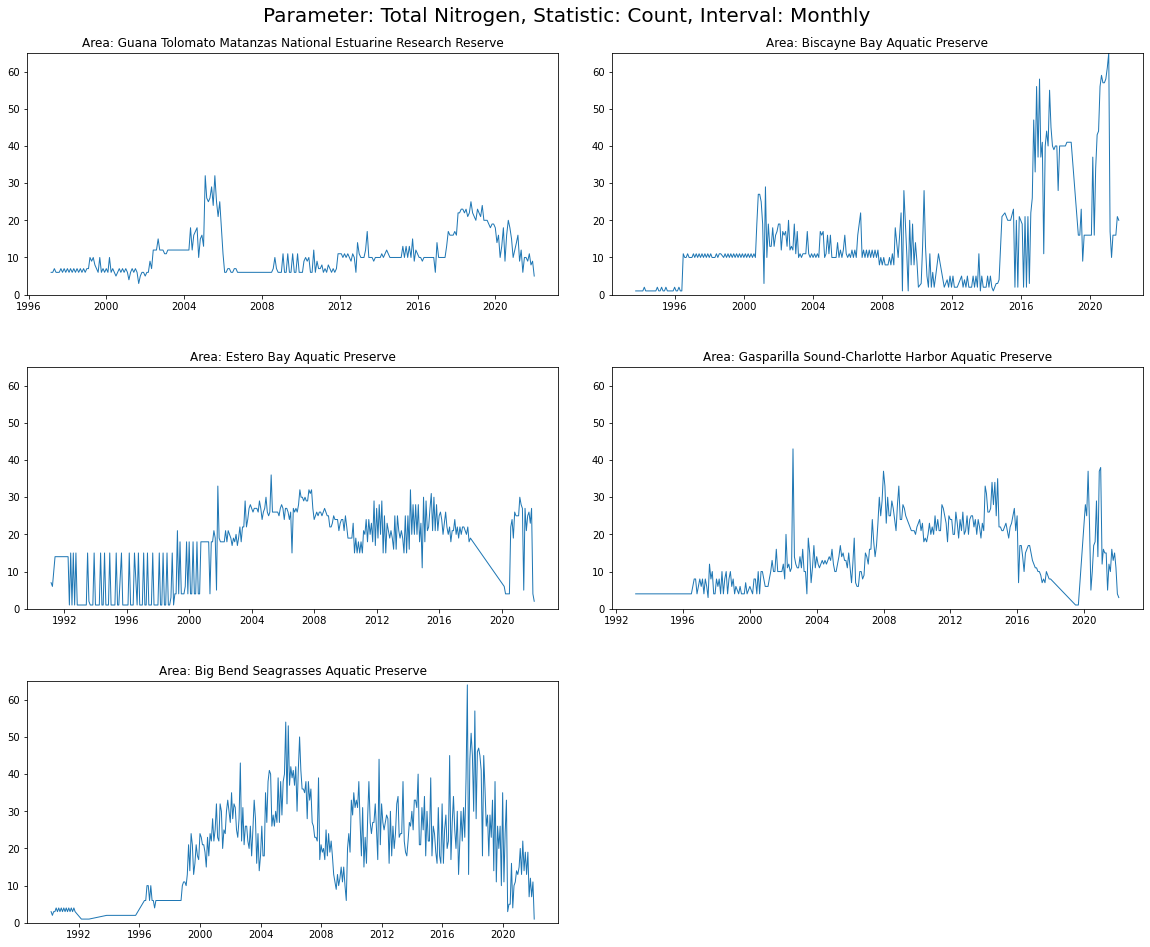

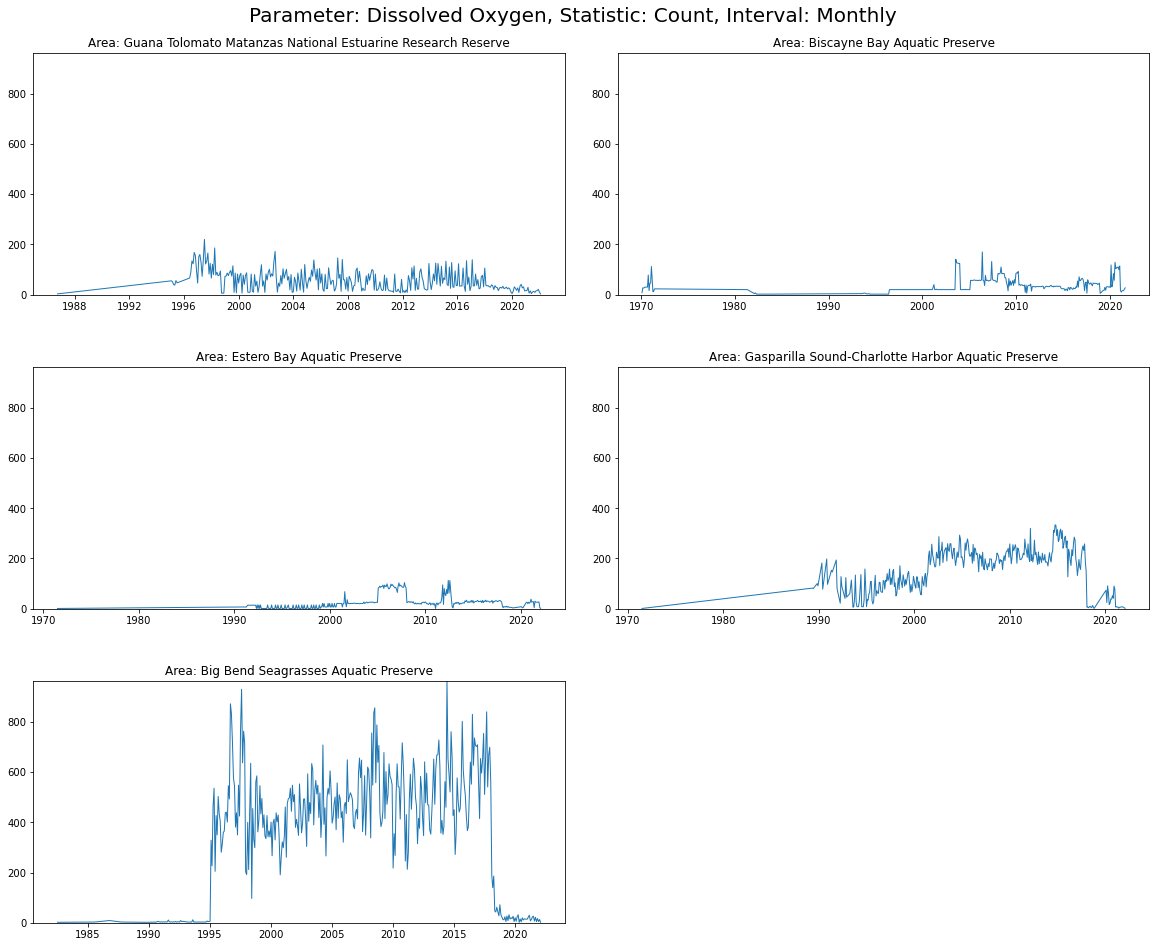

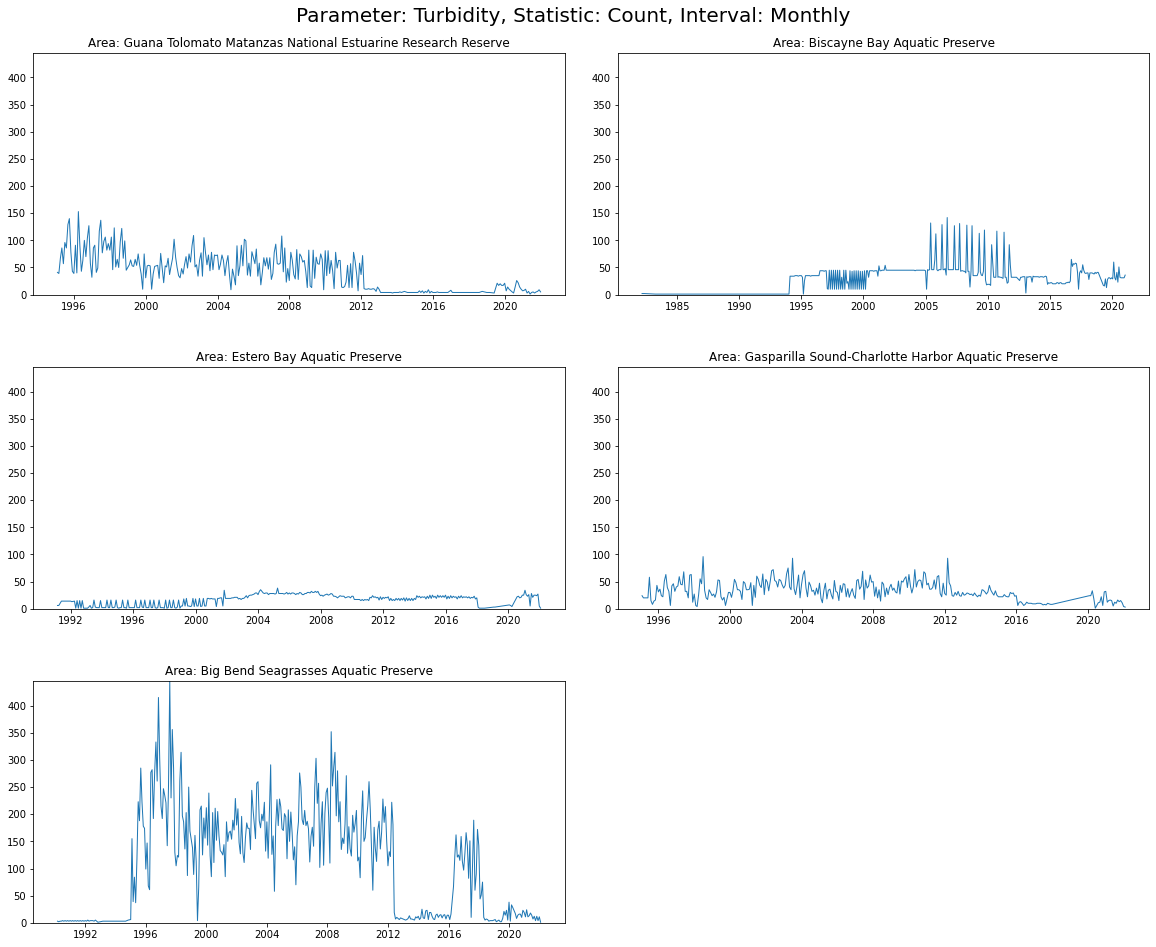

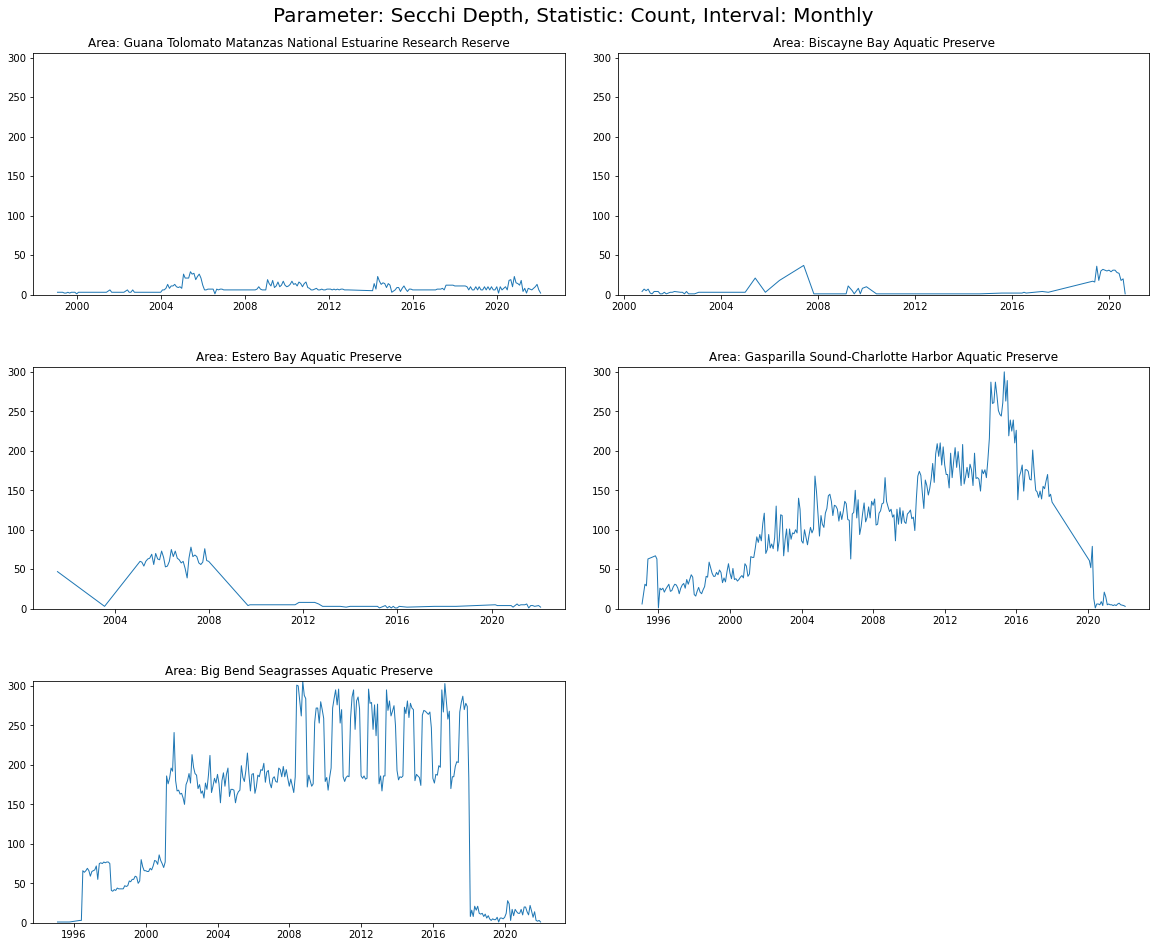

In [272]:
plt.rcParams['figure.figsize'] = [20, 16]
#for value in listValue:
value = listValue[0]
for para in listPara:
    fig = plt.figure()
    # Create the main title
    plt.suptitle("Parameter: " + para + ", Statistic: " + value.capitalize() + ", Interval: Monthly", fontsize = 20, y = 0.92)
    # Calculate the upper limit of y axis
    up_lim = monthly_count[(monthly_count["ParameterName"] == para)]['count'].max()
    for i in range(len(listArea)):
        dfNew = monthly_count[(monthly_count["ParameterName"] == para)&(monthly_count["ManagedAreaName"]== listArea[i])]
        ax = fig.add_subplot(3,2,i+1,title=str('Area: '+ listArea[i]))
        ax.plot(dfNew["timestamp"],dfNew[str(value)],linewidth=1)
        ax.set_ylim([0,up_lim])
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

### 2.3 Plotting Maximum values in monthly intervals

This is to identify anomalies in the data.

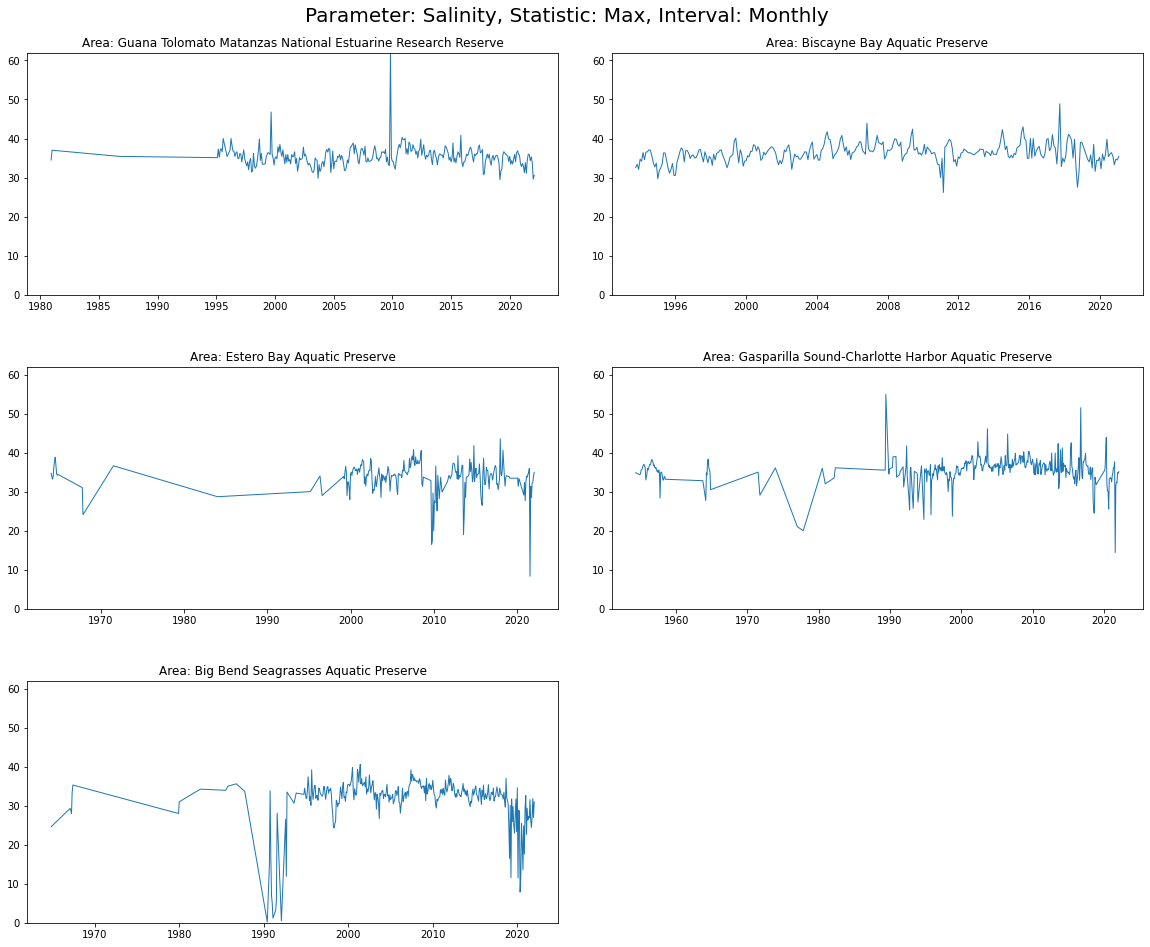

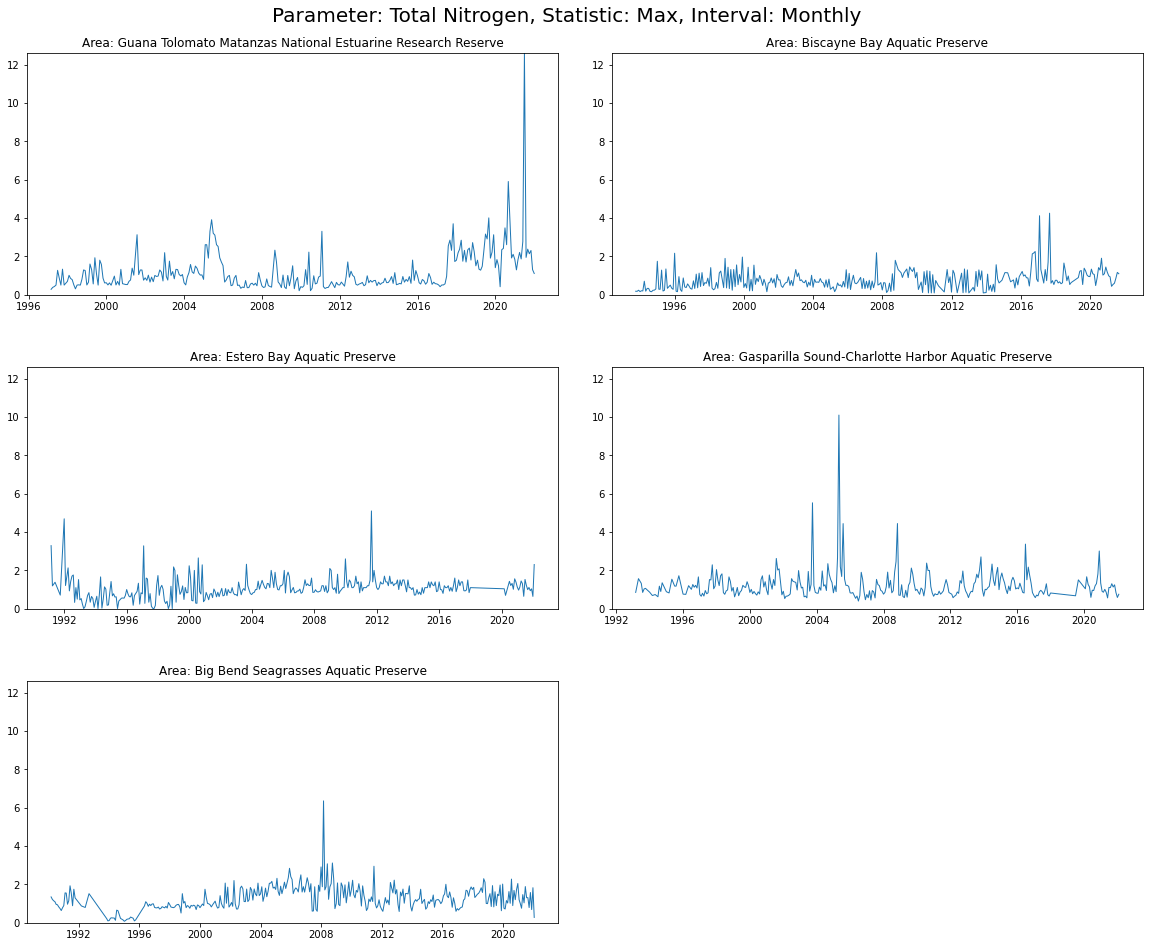

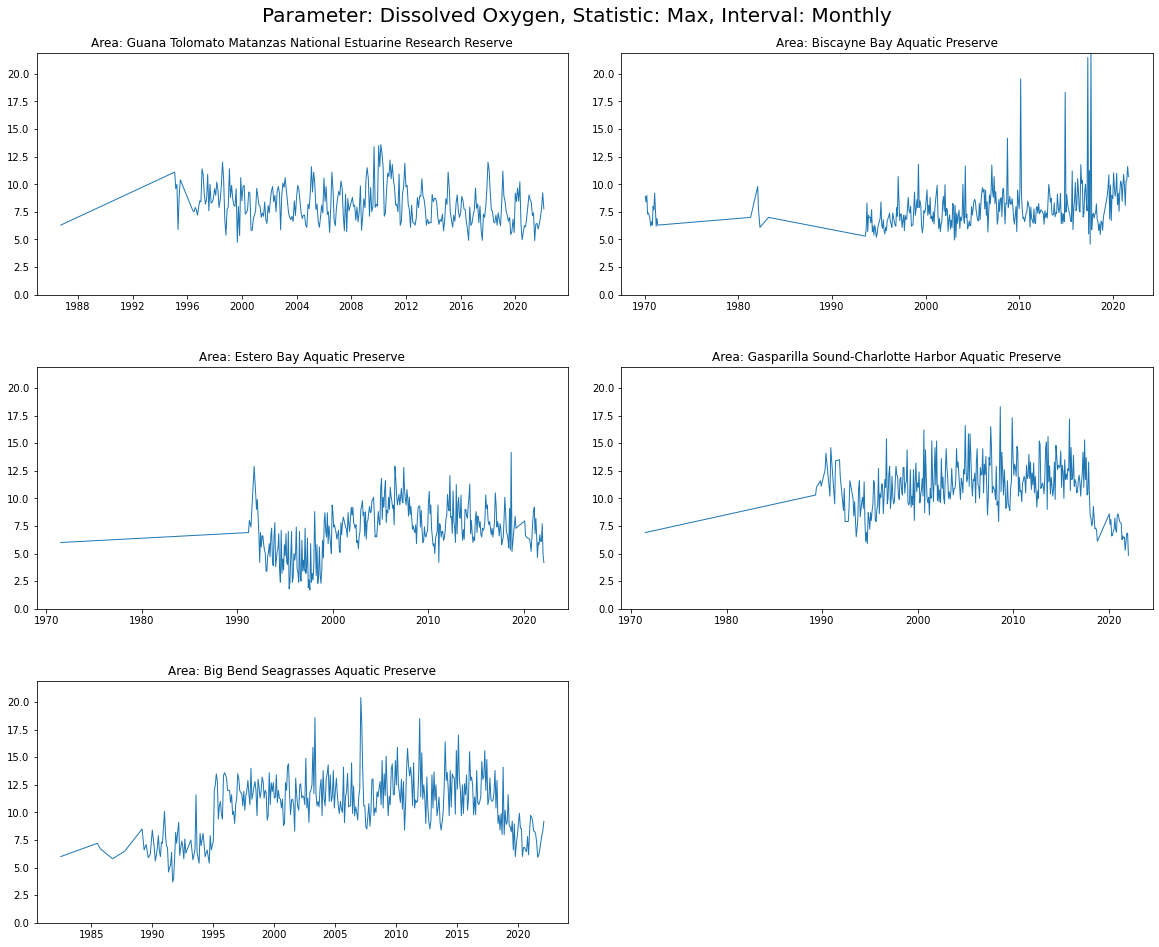

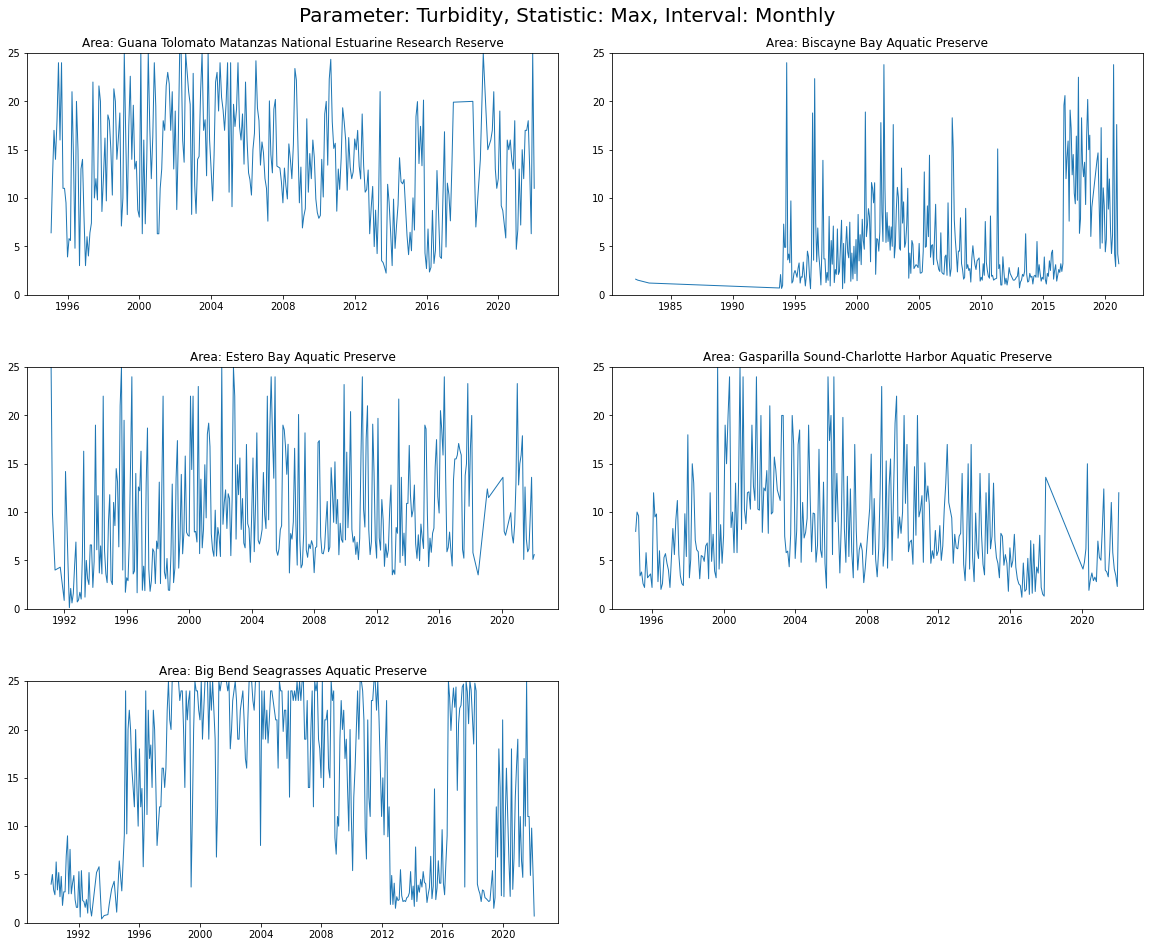

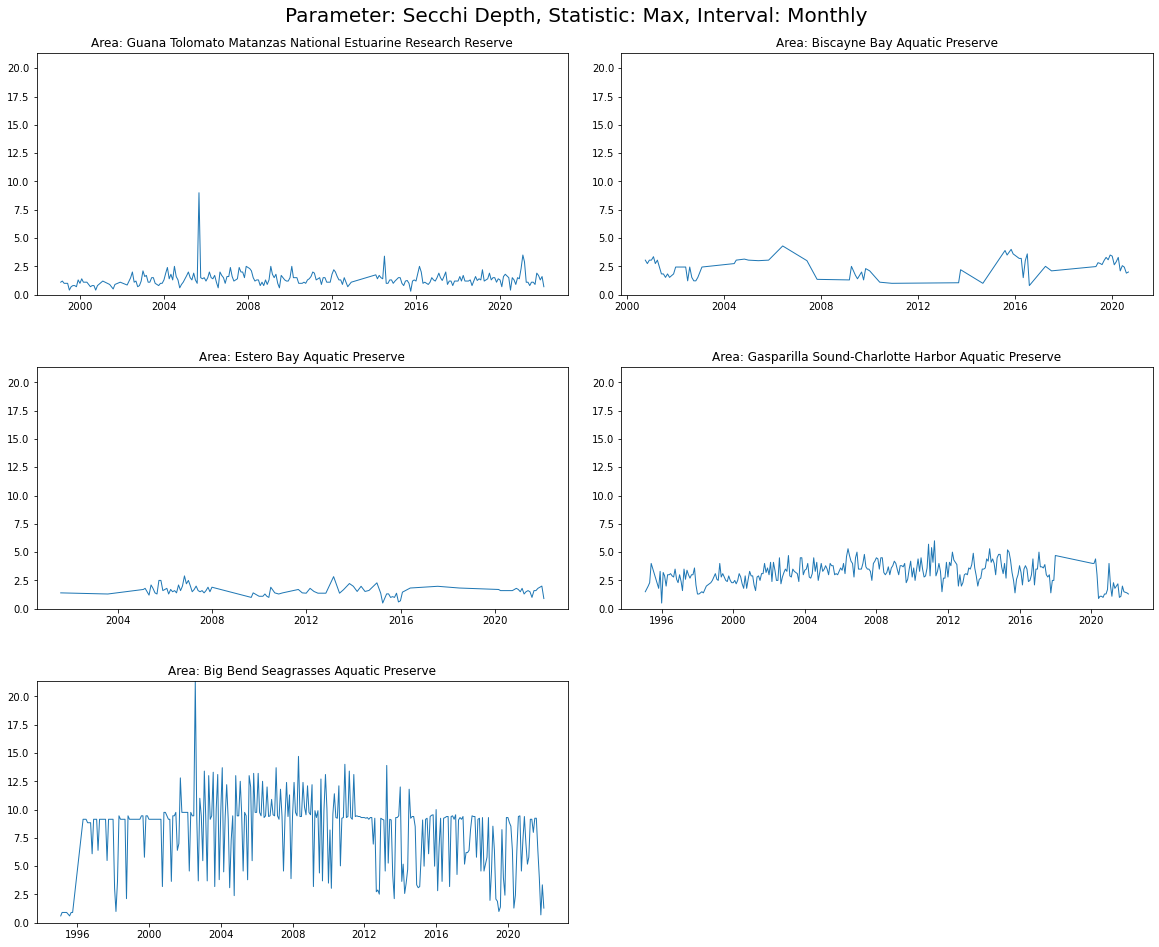

In [220]:
plt.rcParams['figure.figsize'] = [20, 16]
#for value in listValue:
value = 'max'
for para in listPara:
    fig = plt.figure()
    # Create the main title
    plt.suptitle("Parameter: " + para + ", Statistic: " + value.capitalize() + ", Interval: Monthly", fontsize = 20, y = 0.92)
    # Calculate the upper limit of y axis
    up_lim = monthly_count[(monthly_count["ParameterName"] == para)][value].max()
    for i in range(len(listArea)):
        dfNew = monthly_count[(monthly_count["ParameterName"] == para)&(monthly_count["ManagedAreaName"]== listArea[i])]
        ax = fig.add_subplot(3,2,i+1,title=str('Area: '+ listArea[i]))
        ax.plot(dfNew["timestamp"],dfNew[str(value)],linewidth=1)
        ax.set_ylim([0,up_lim])
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

### 2.3 Monthly Error Bar

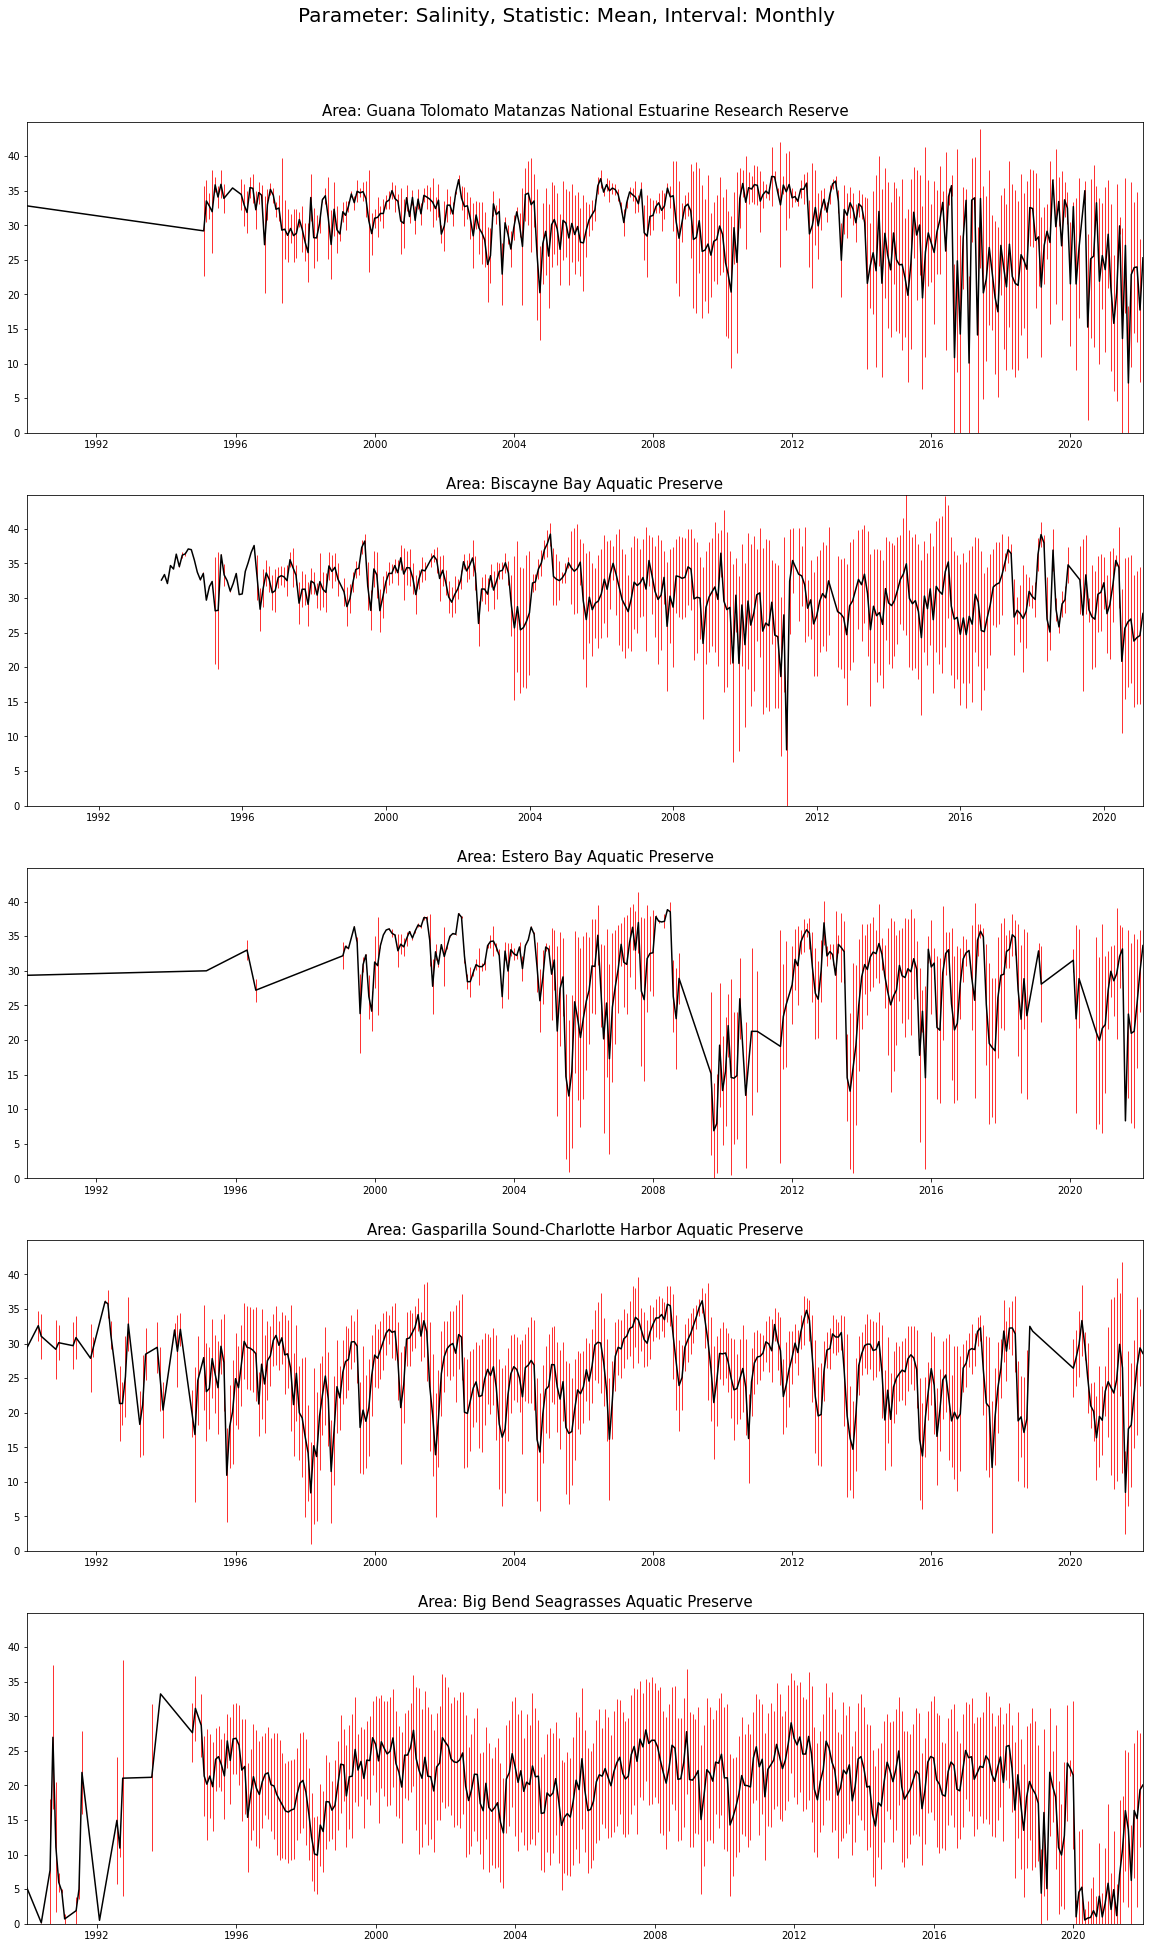

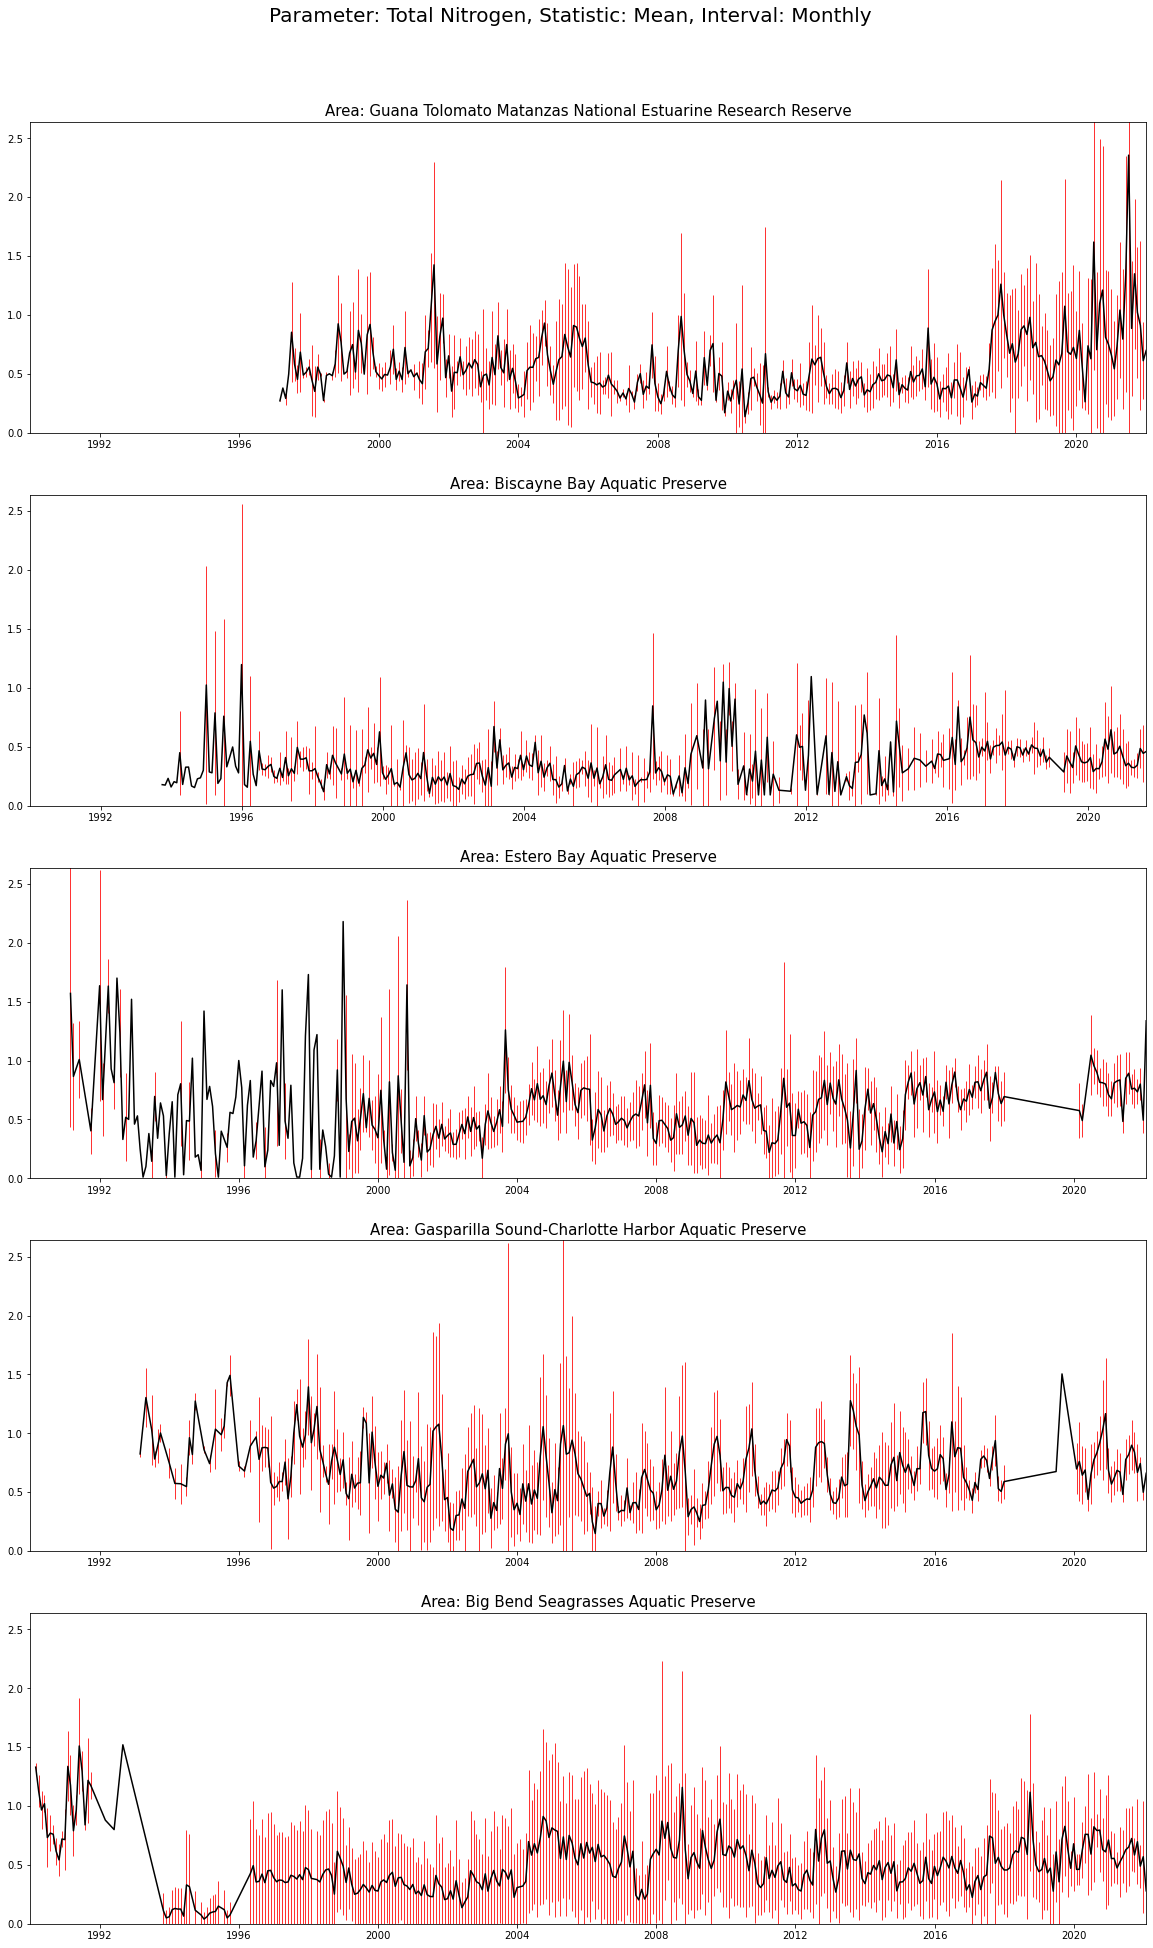

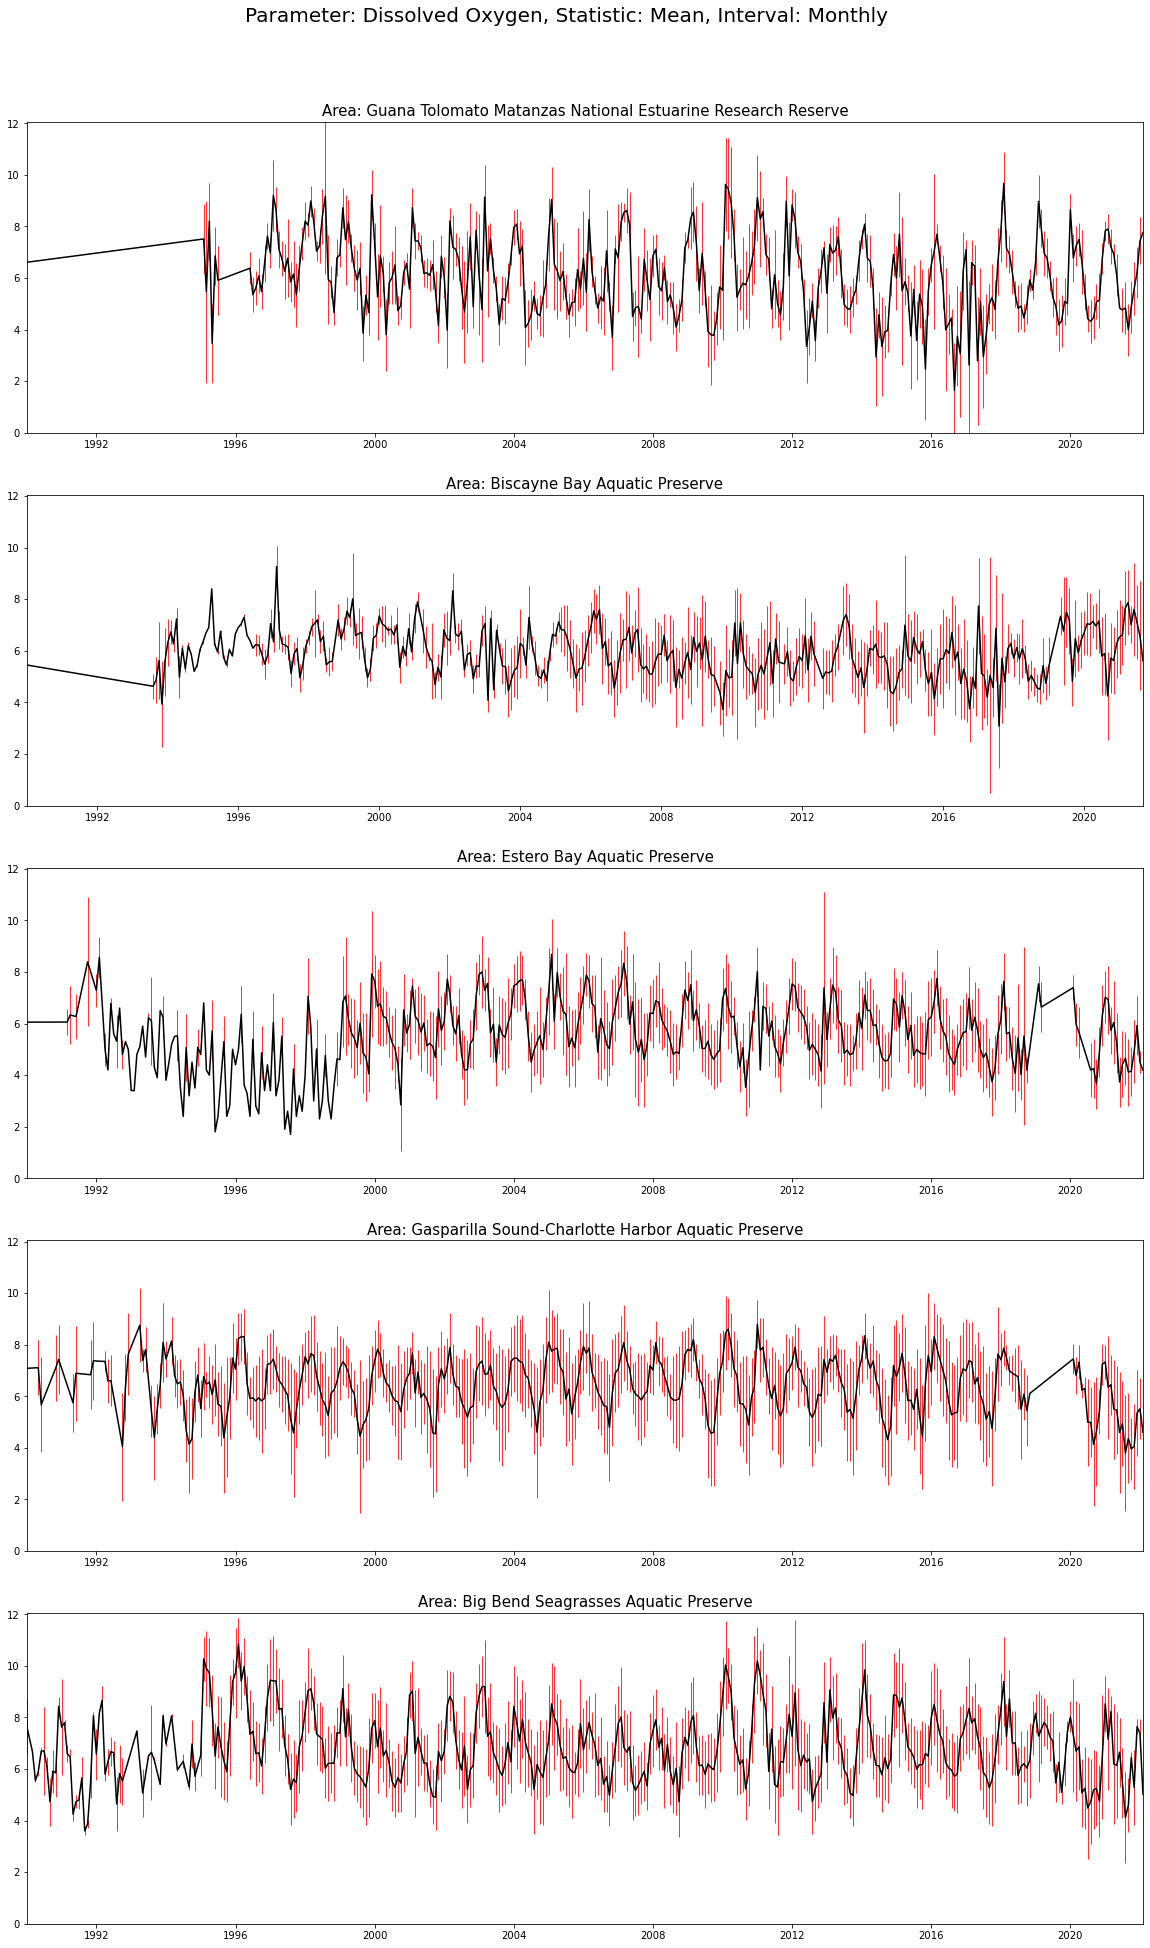

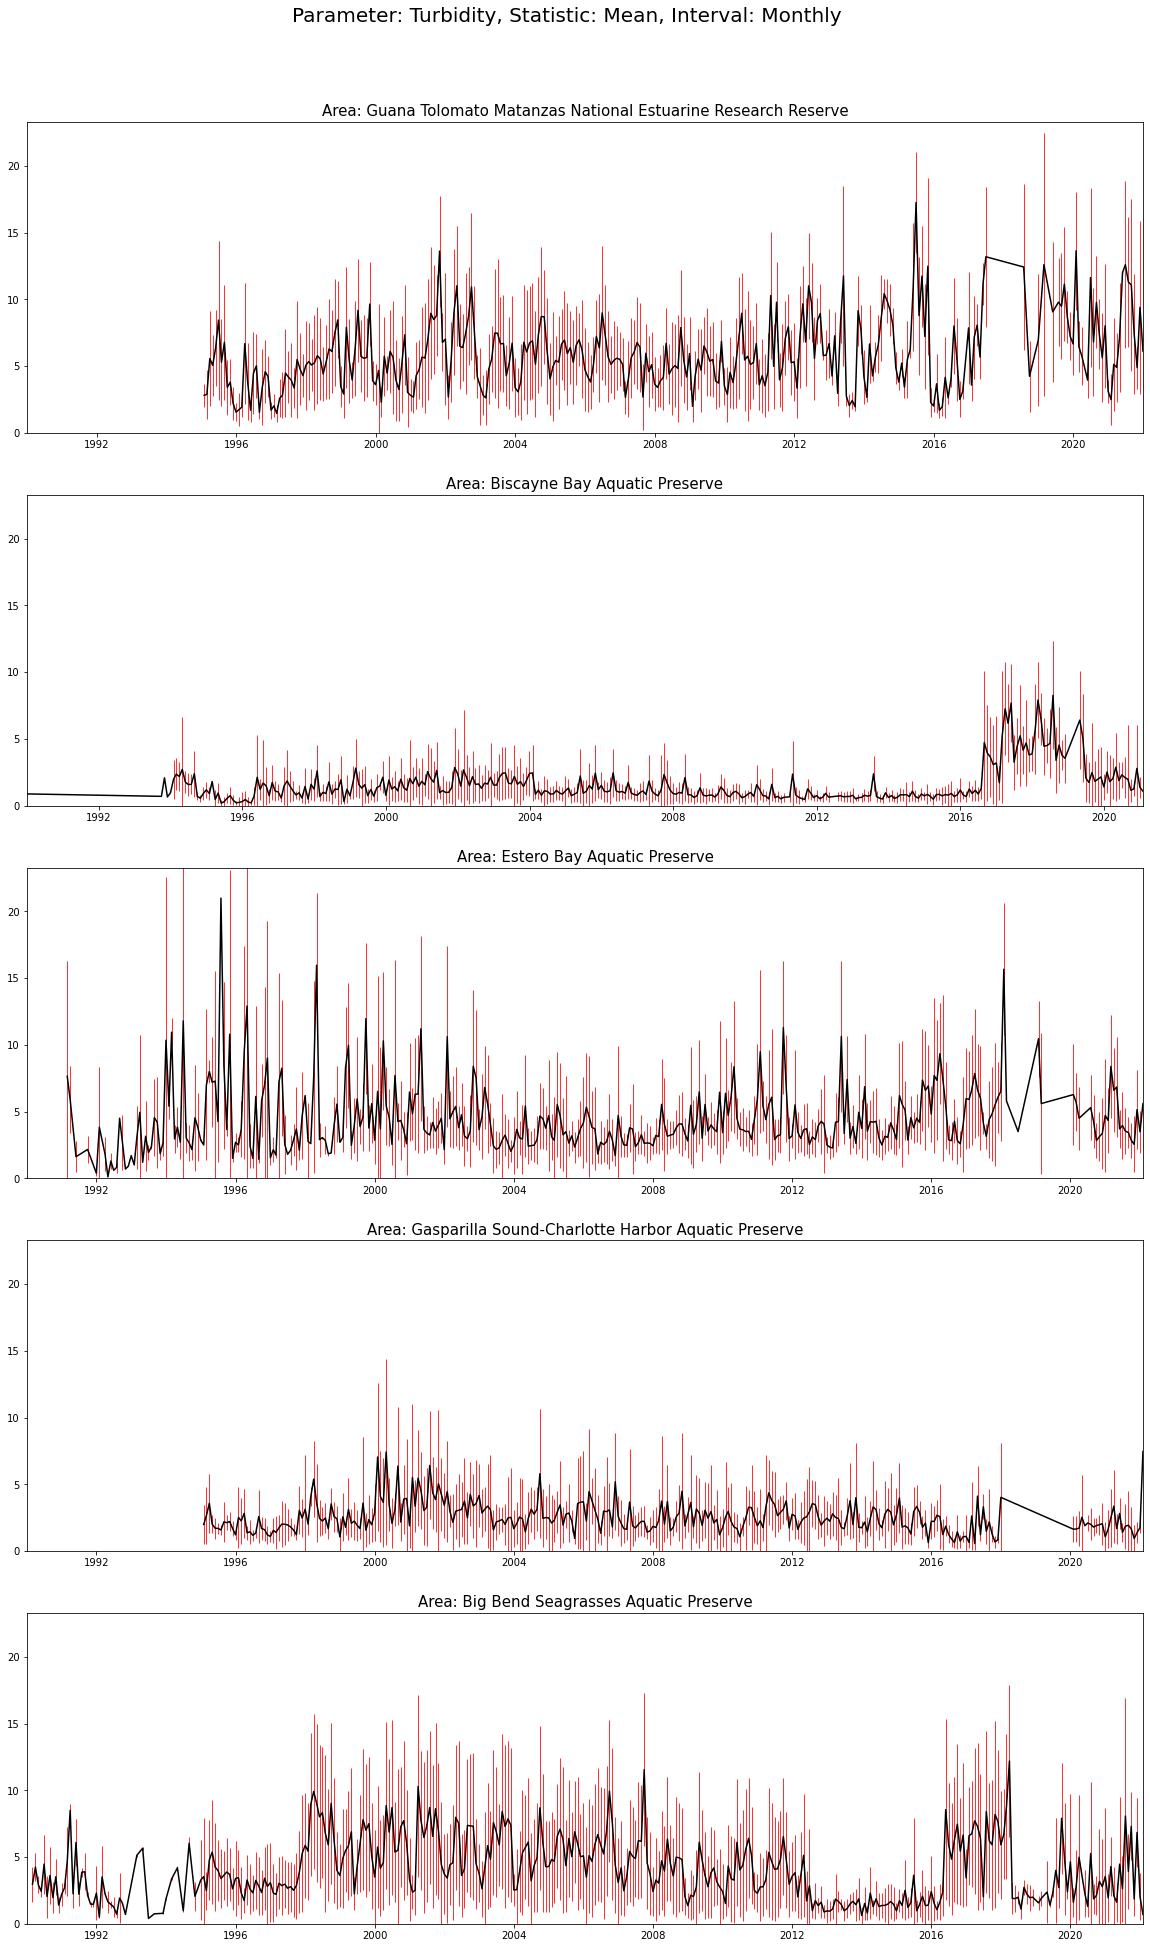

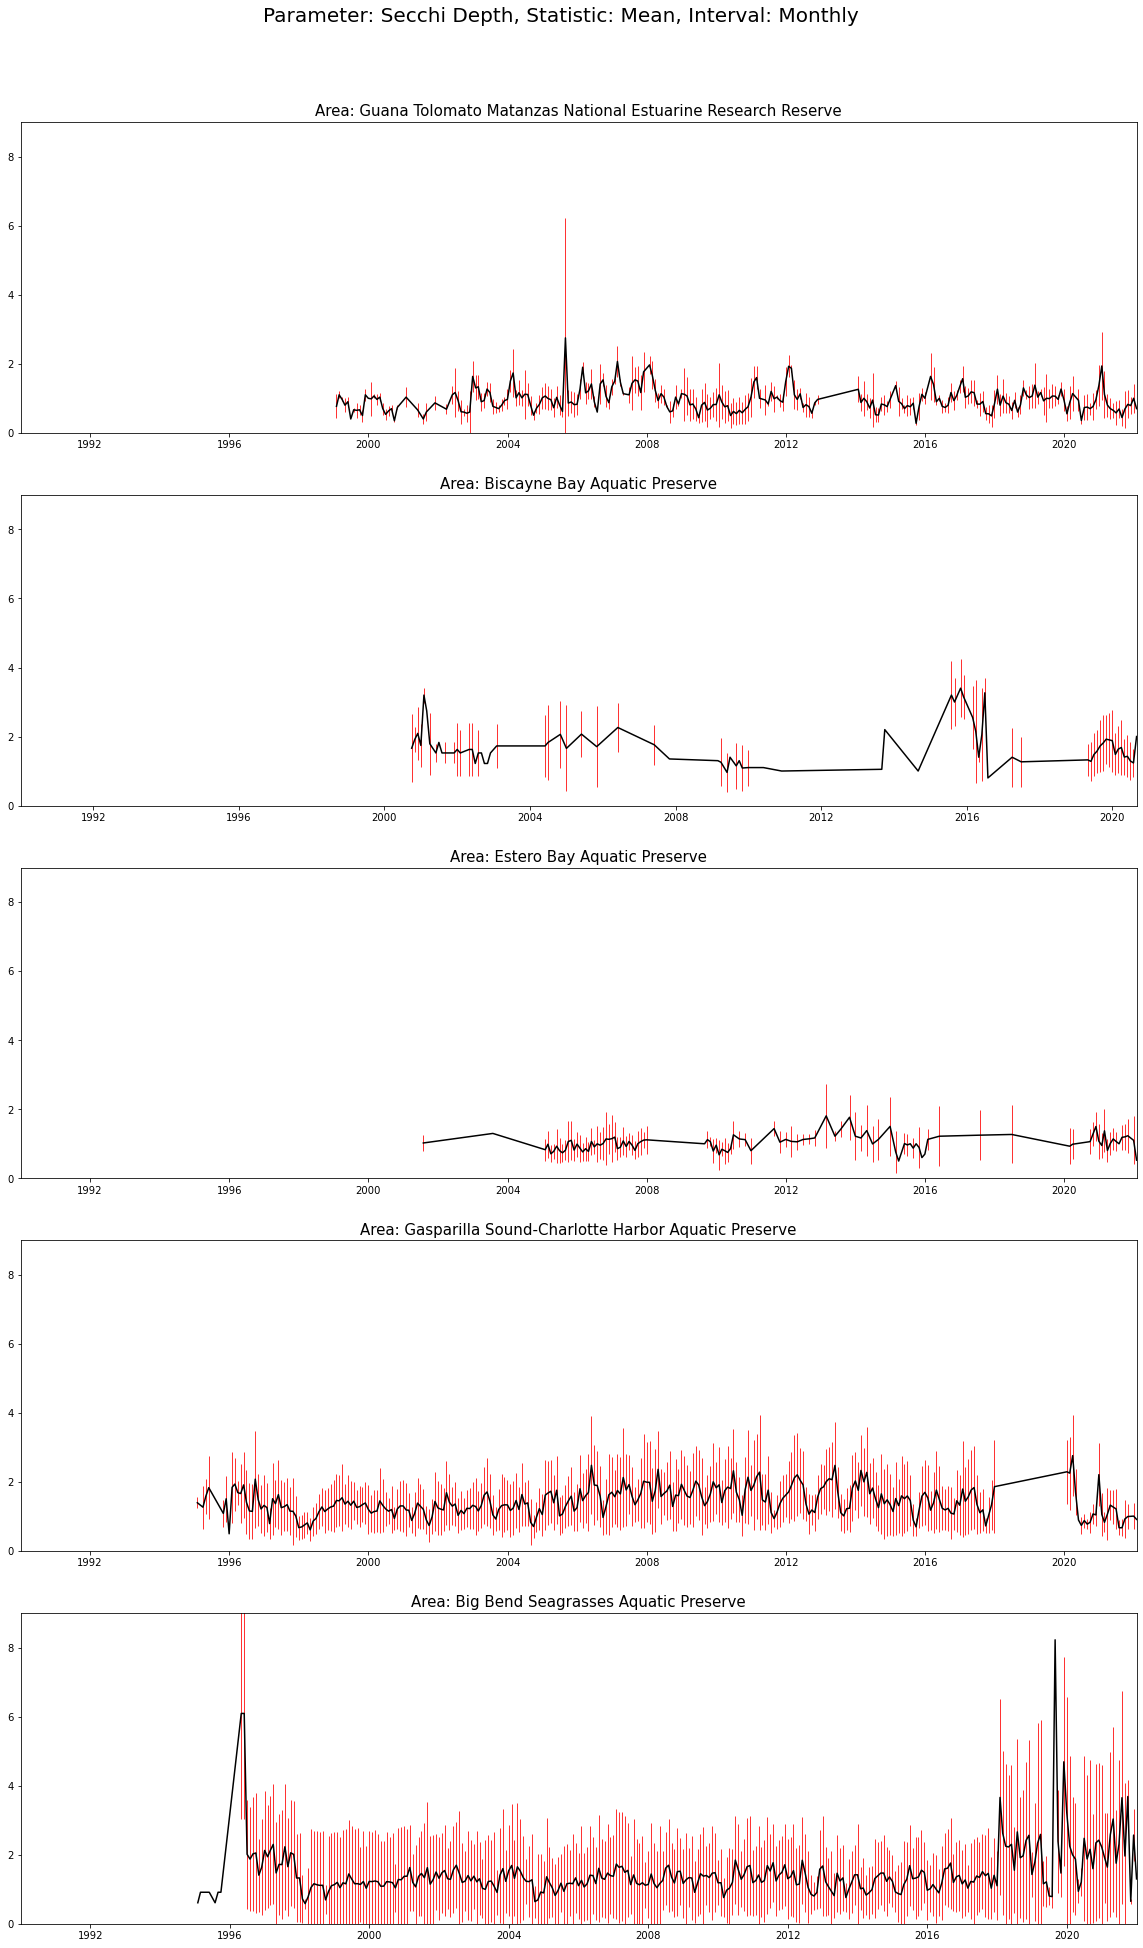

In [221]:
plt.rcParams['figure.figsize'] = [20, 40]
#for value in listValue:
value = listValue[1]
for para in listPara:
    fig = plt.figure()
    # Create the main title
    plt.suptitle("Parameter: " + para + ", Statistic: " + value.capitalize() + ", Interval: Monthly", fontsize = 20, y = 0.92)
    # Calculate the upper limit of y axis
    stats = monthly_count[(monthly_count["ParameterName"] == para)]
    up_lim = stats['mean'].max()+stats['std'].mean()
    for i in range(len(listArea)):
        dfNew = monthly_count[(monthly_count["ParameterName"] == para)&(monthly_count["ManagedAreaName"]== listArea[i])]
        ax = fig.add_subplot(6,1,i+1)
        
        # Set title and font size
        ax.set_title('Area: '+ str(listArea[i]), size=15) # Title
        
        ax.errorbar(dfNew["timestamp"],dfNew['mean'],dfNew['std'],ecolor='red',elinewidth = 0.8,color="black")
        # Set limit of x and y axis
        ax.set_ylim([0,up_lim])
        ax.set_xlim([pd.Timestamp('1990-01-01'),dfNew["timestamp"].max()])
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1)

### 2.4 Yearly Error Bars

Black line is the mean and red lines are -1/+1 standard deviation.

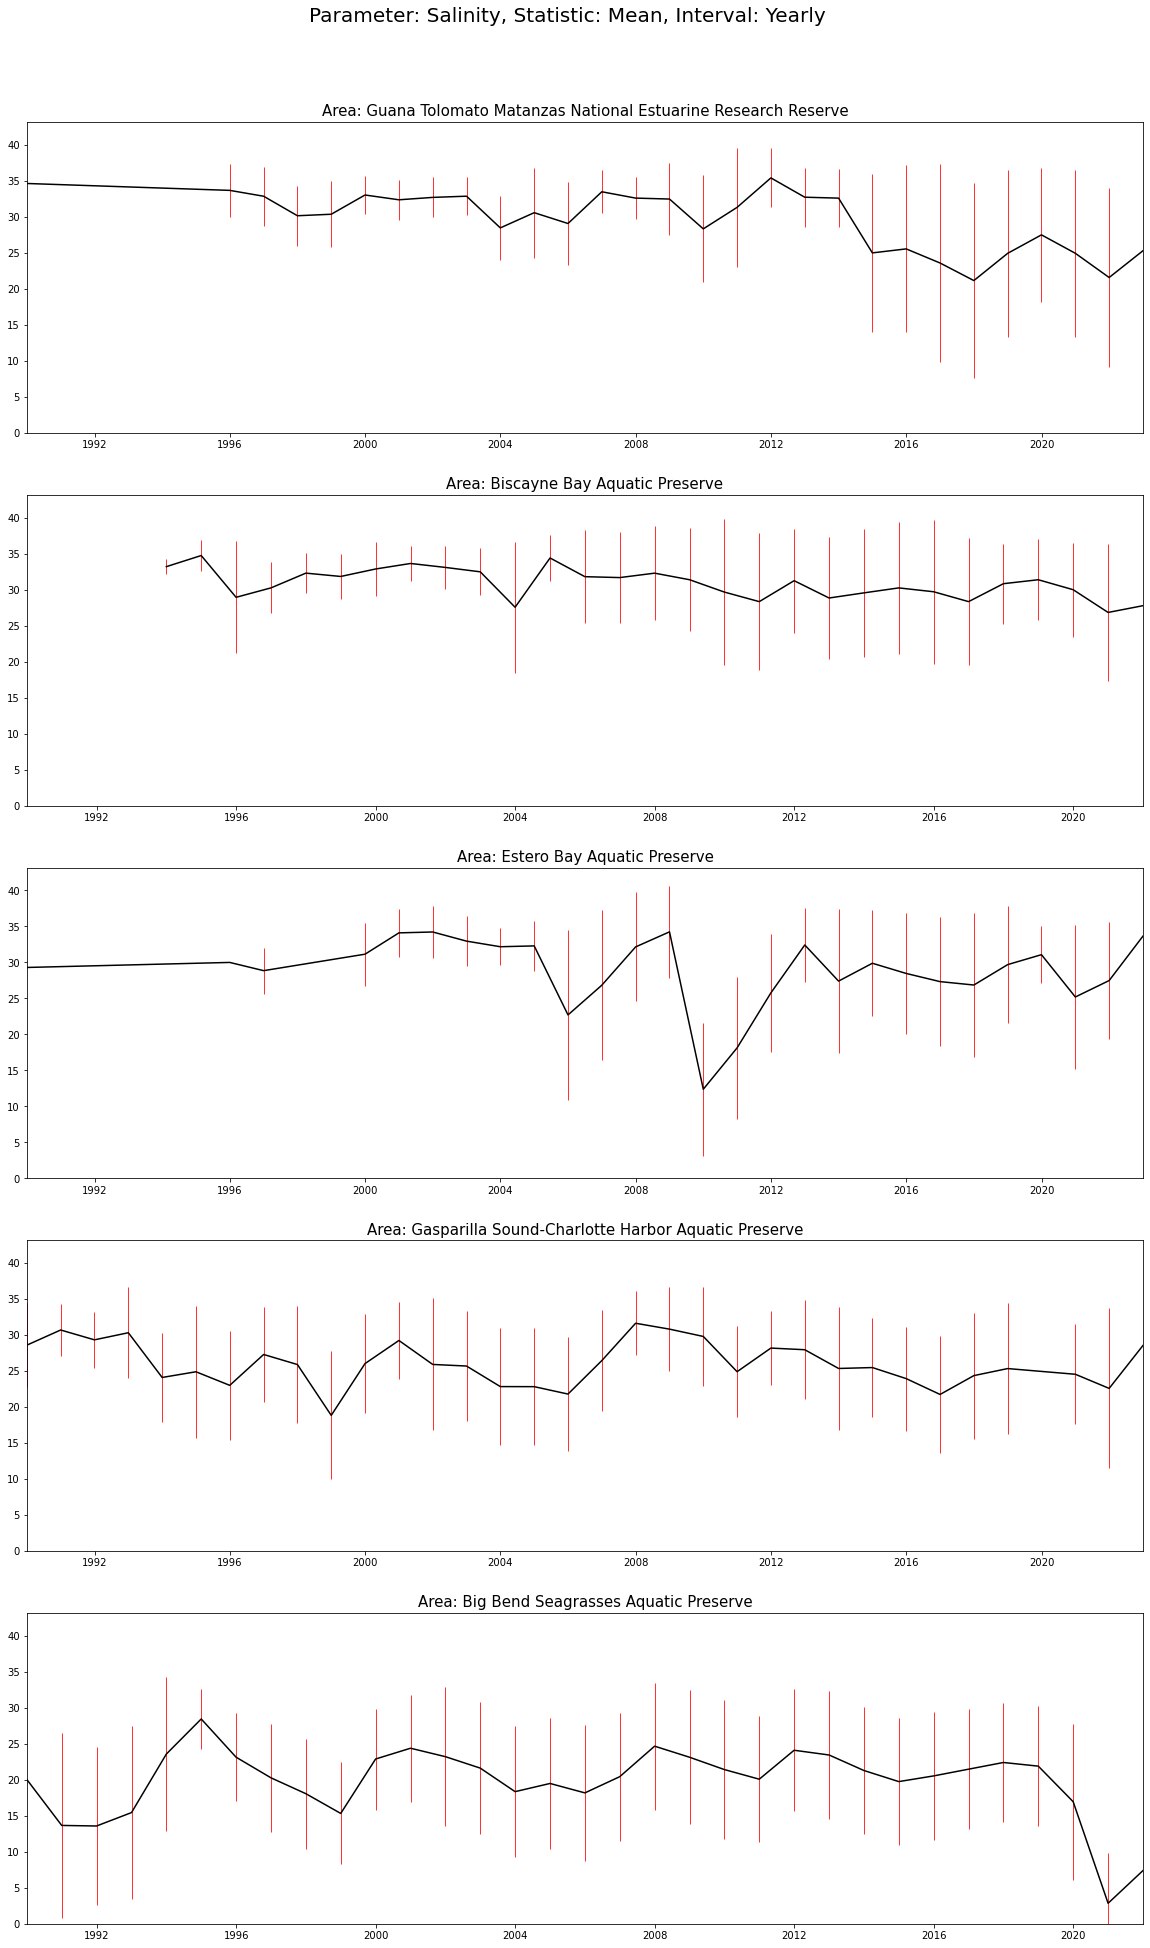

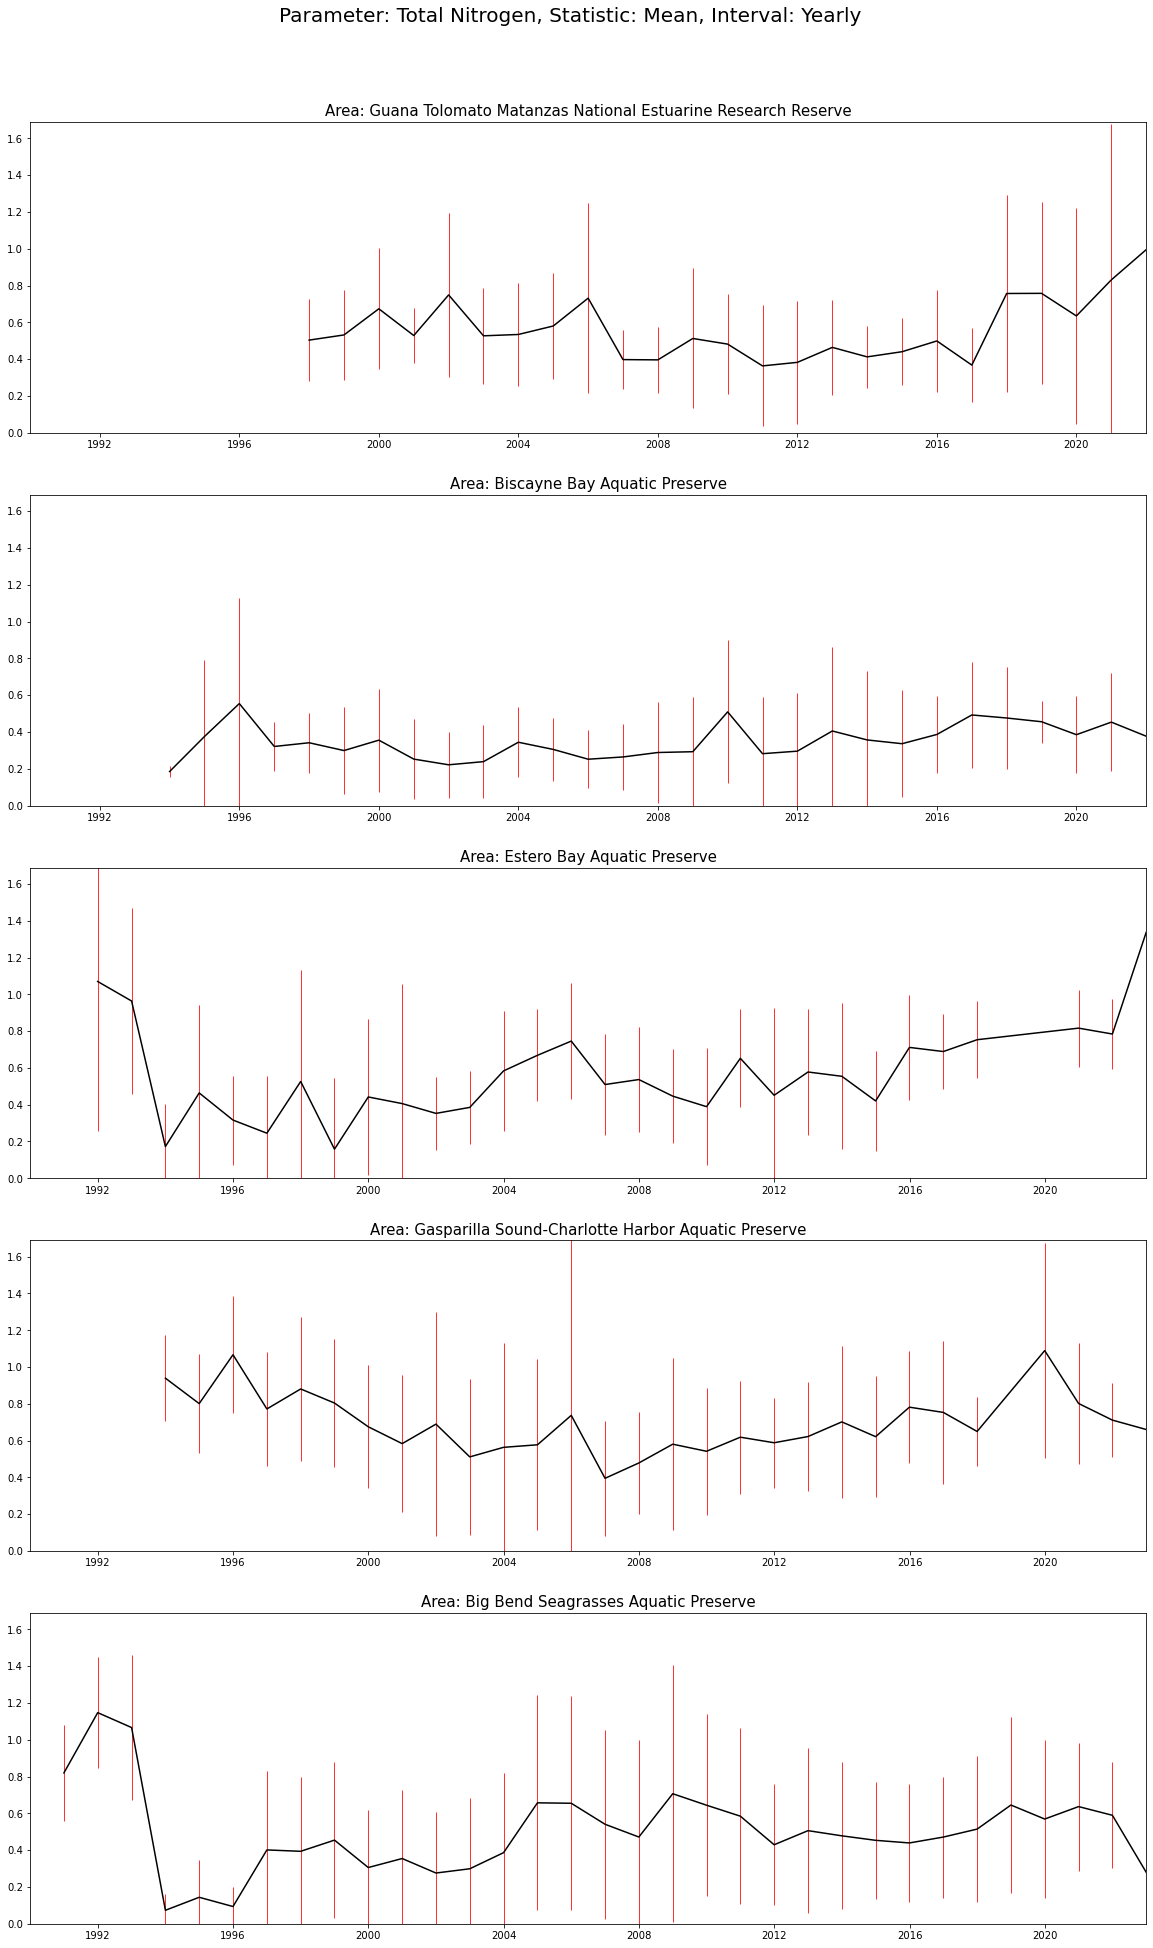

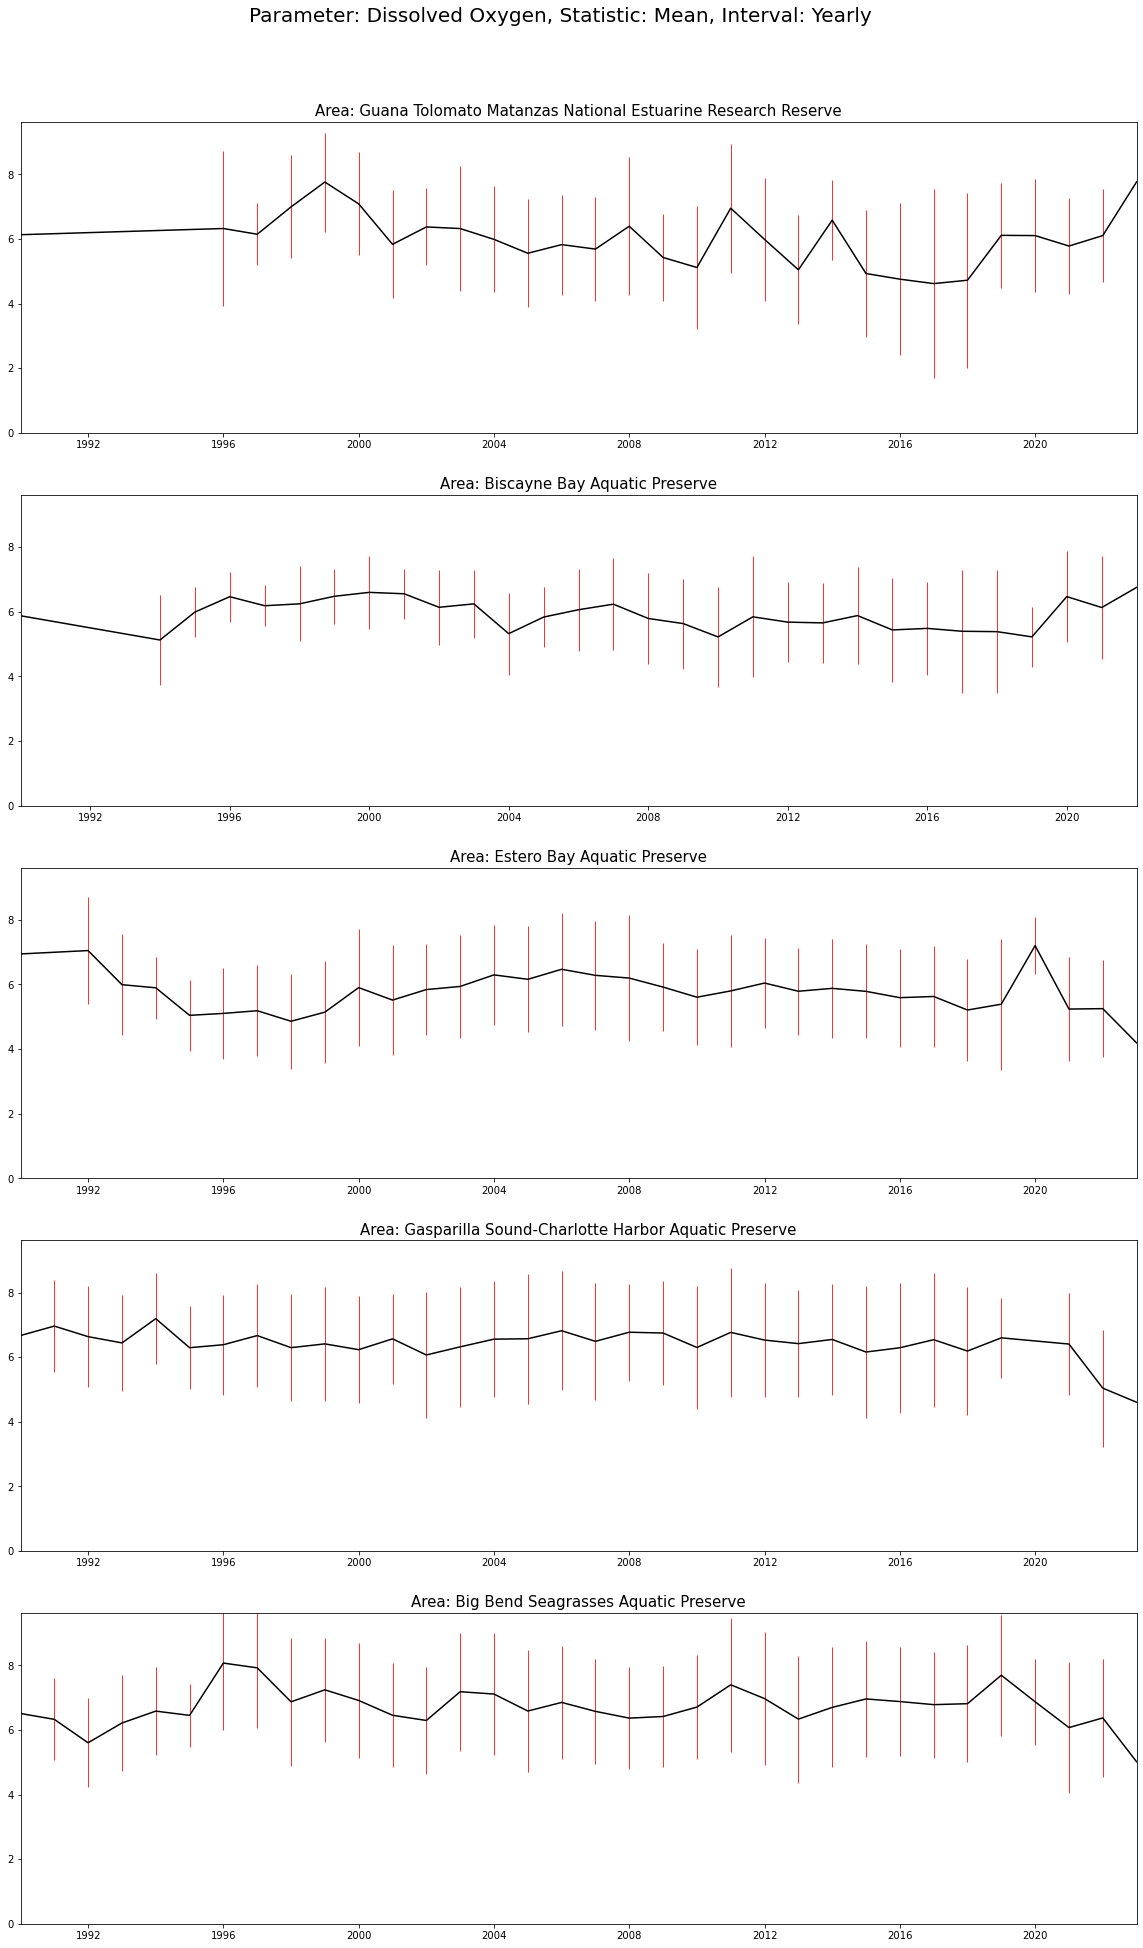

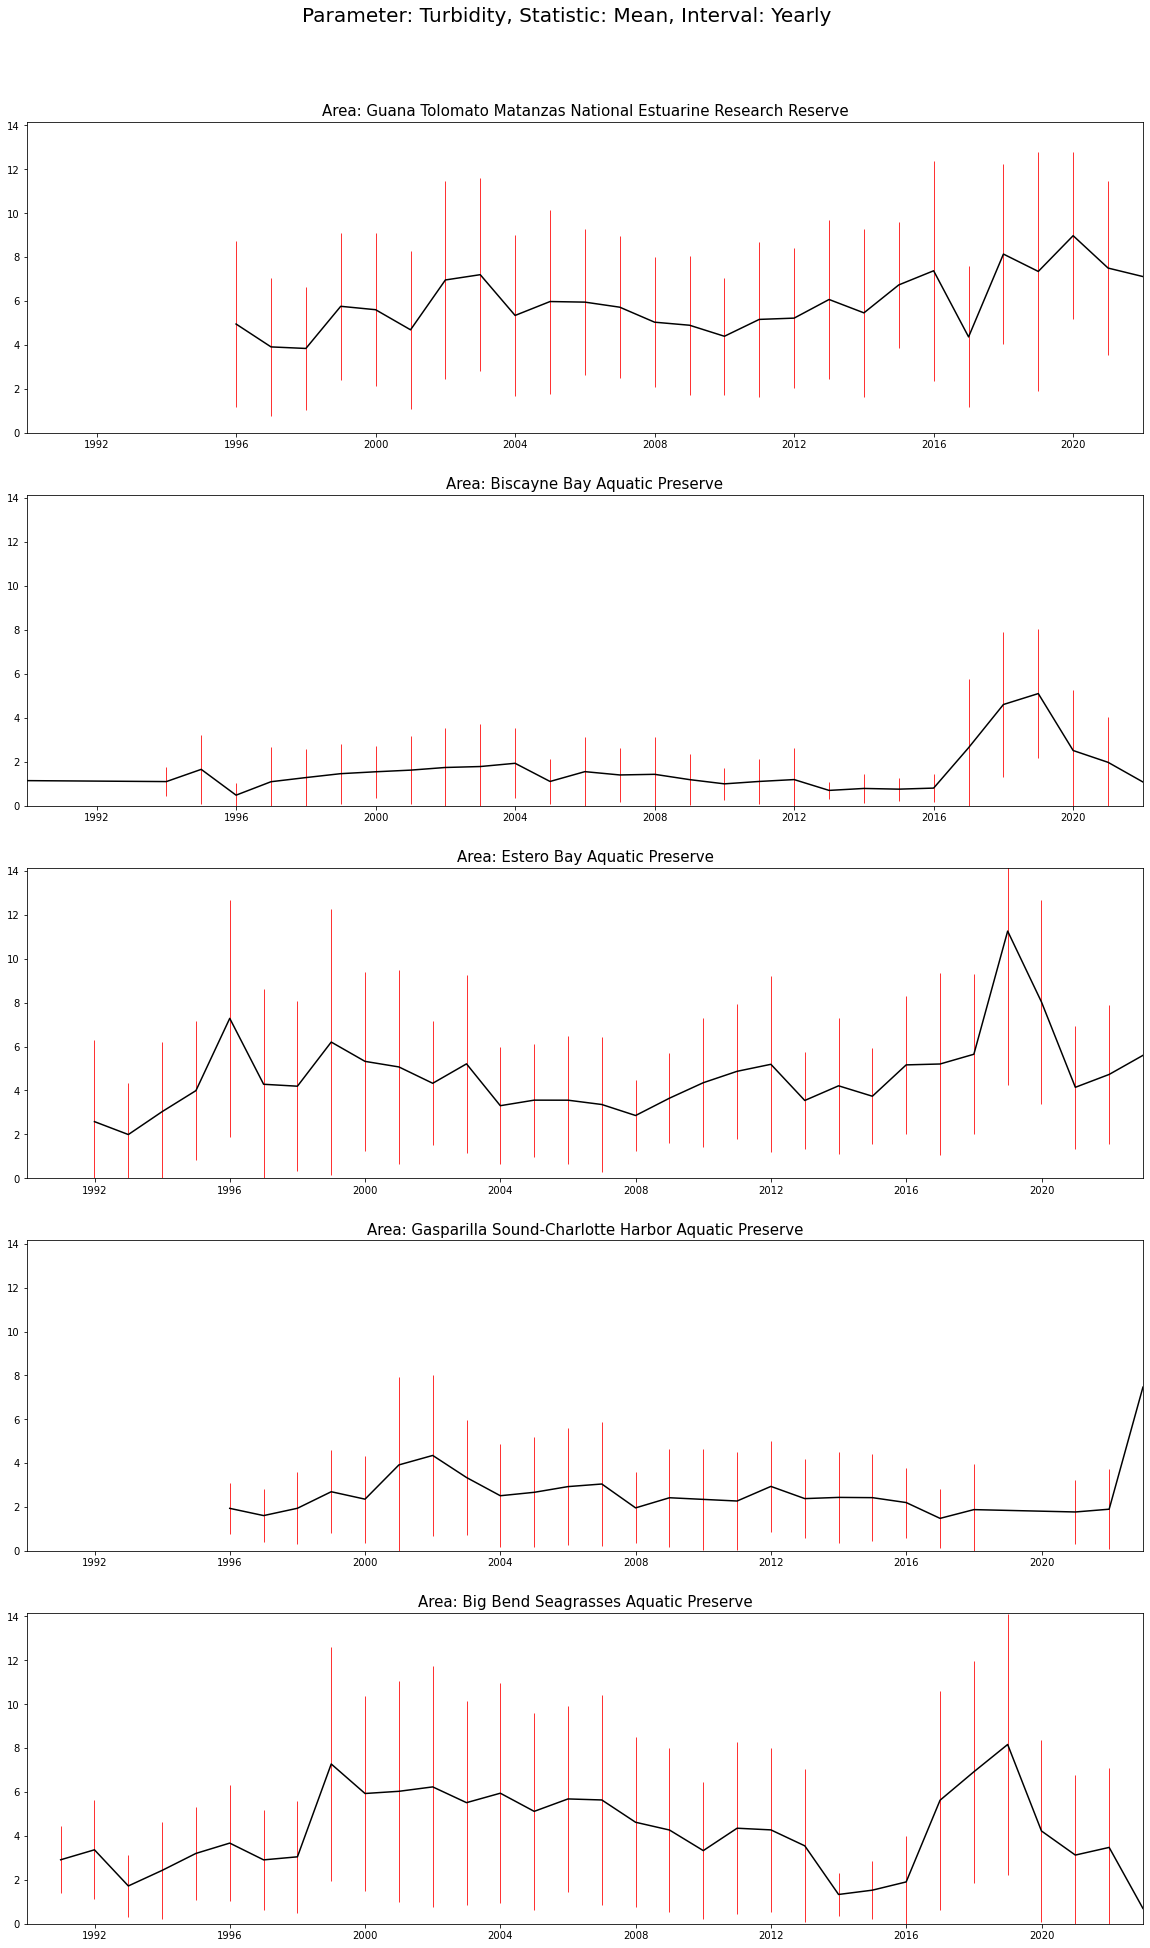

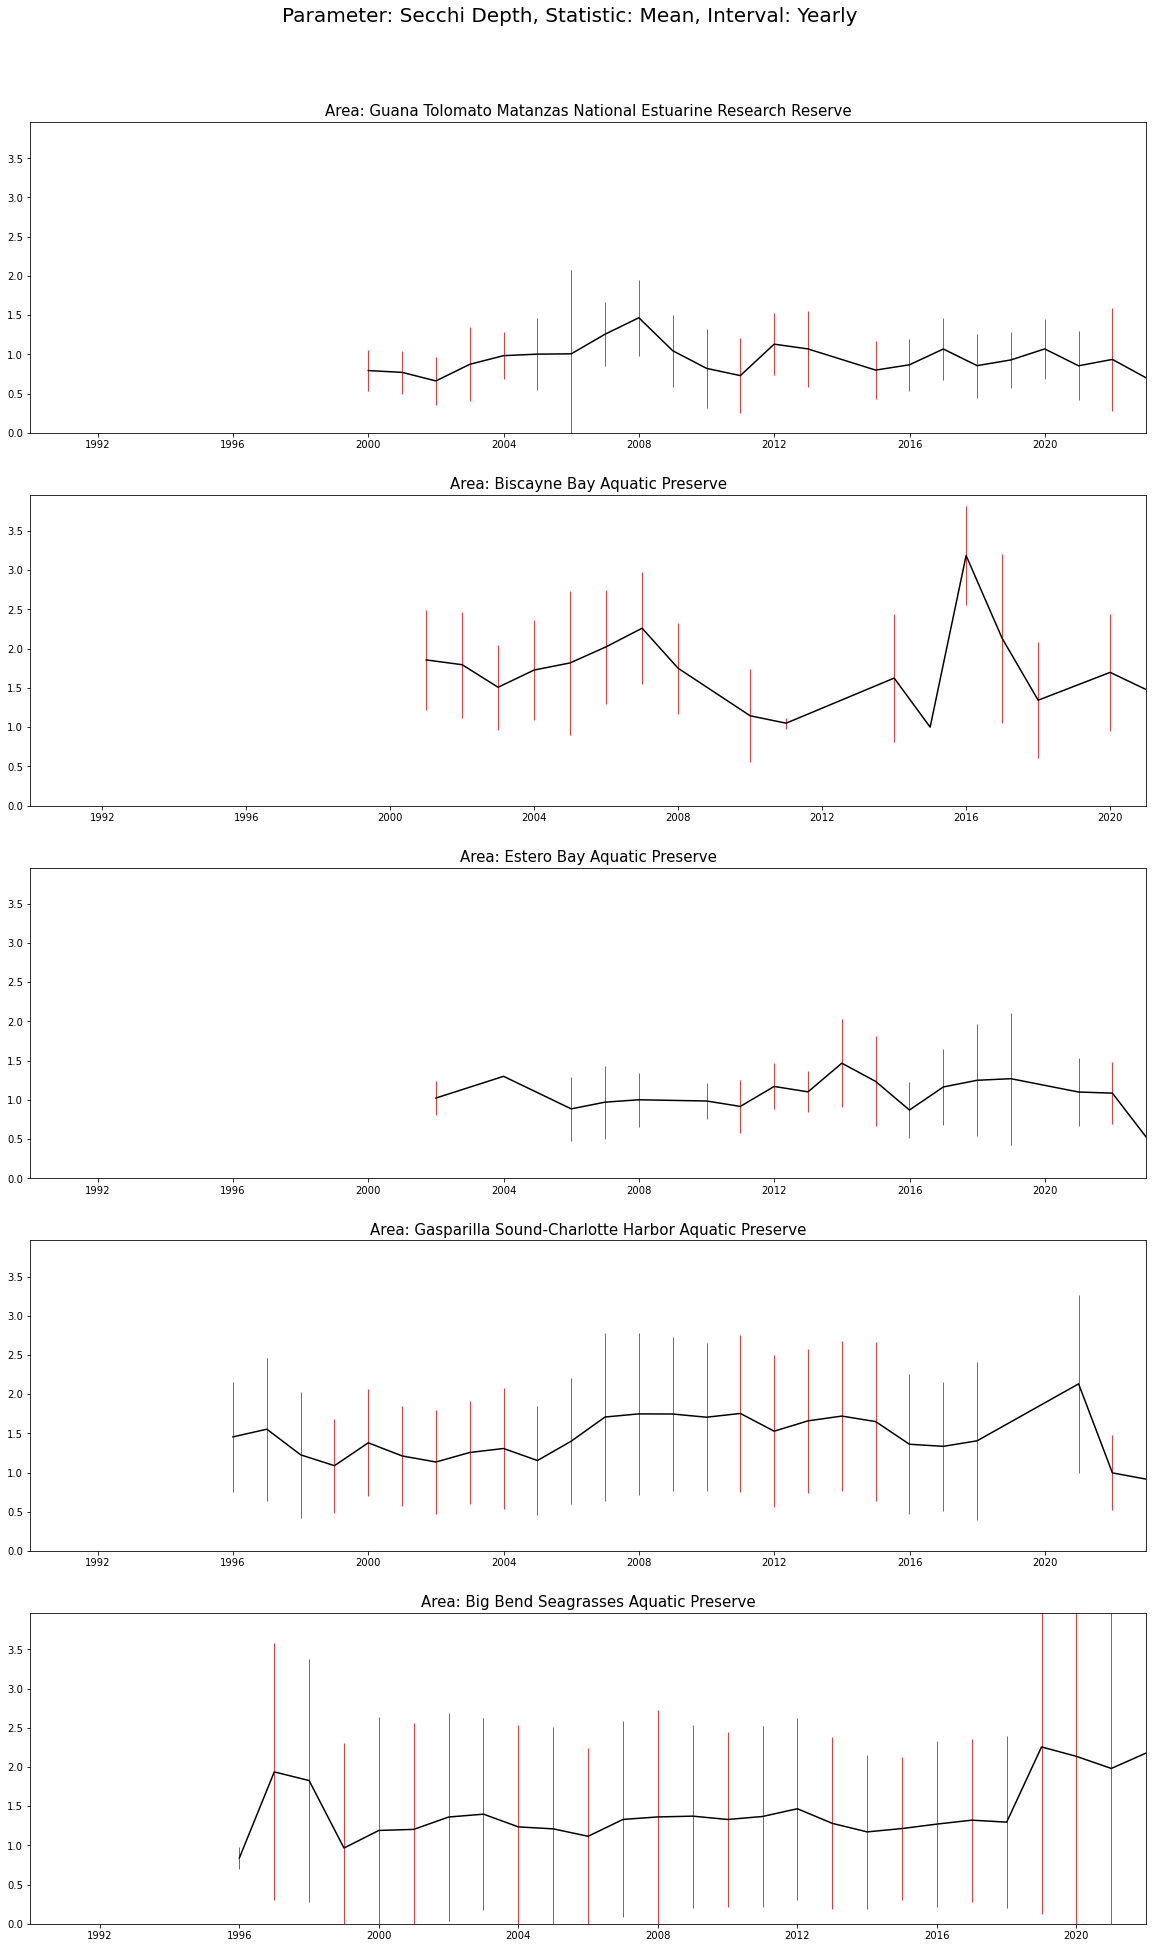

In [222]:
plt.rcParams['figure.figsize'] = [20, 40]
#for value in listValue:
value = listValue[1]
for para in listPara:
    fig = plt.figure()
    # Create the main title
    plt.suptitle("Parameter: " + para + ", Statistic: " + value.capitalize() + ", Interval: Yearly", fontsize = 20, y = 0.92)
    # Calculate the upper limit of y axis
    stats = yearly_count[(yearly_count["ParameterName"] == para)]
    up_lim = stats['mean'].max()+stats['std'].mean()
    for i in range(len(listArea)):
        dfNew = yearly_count[(yearly_count["ParameterName"] == para) & (yearly_count["ManagedAreaName"]== listArea[i])]
        ax = fig.add_subplot(6,1,i+1)
        
        # Set title and font size
        ax.set_title('Area: '+ str(listArea[i]), size=15) # Title
        
        ax.errorbar(dfNew["timestamp"],dfNew['mean'],dfNew['std'],ecolor='red',elinewidth = 0.8,color="black")
        # Set limit of x and y axis
        ax.set_ylim([0,up_lim])
        ax.set_xlim([pd.Timestamp('1990-01-01'),dfNew["timestamp"].max()])
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1)

### 2.5 Statistics by Months

The following boxplots are statistics in the same months in different years. 

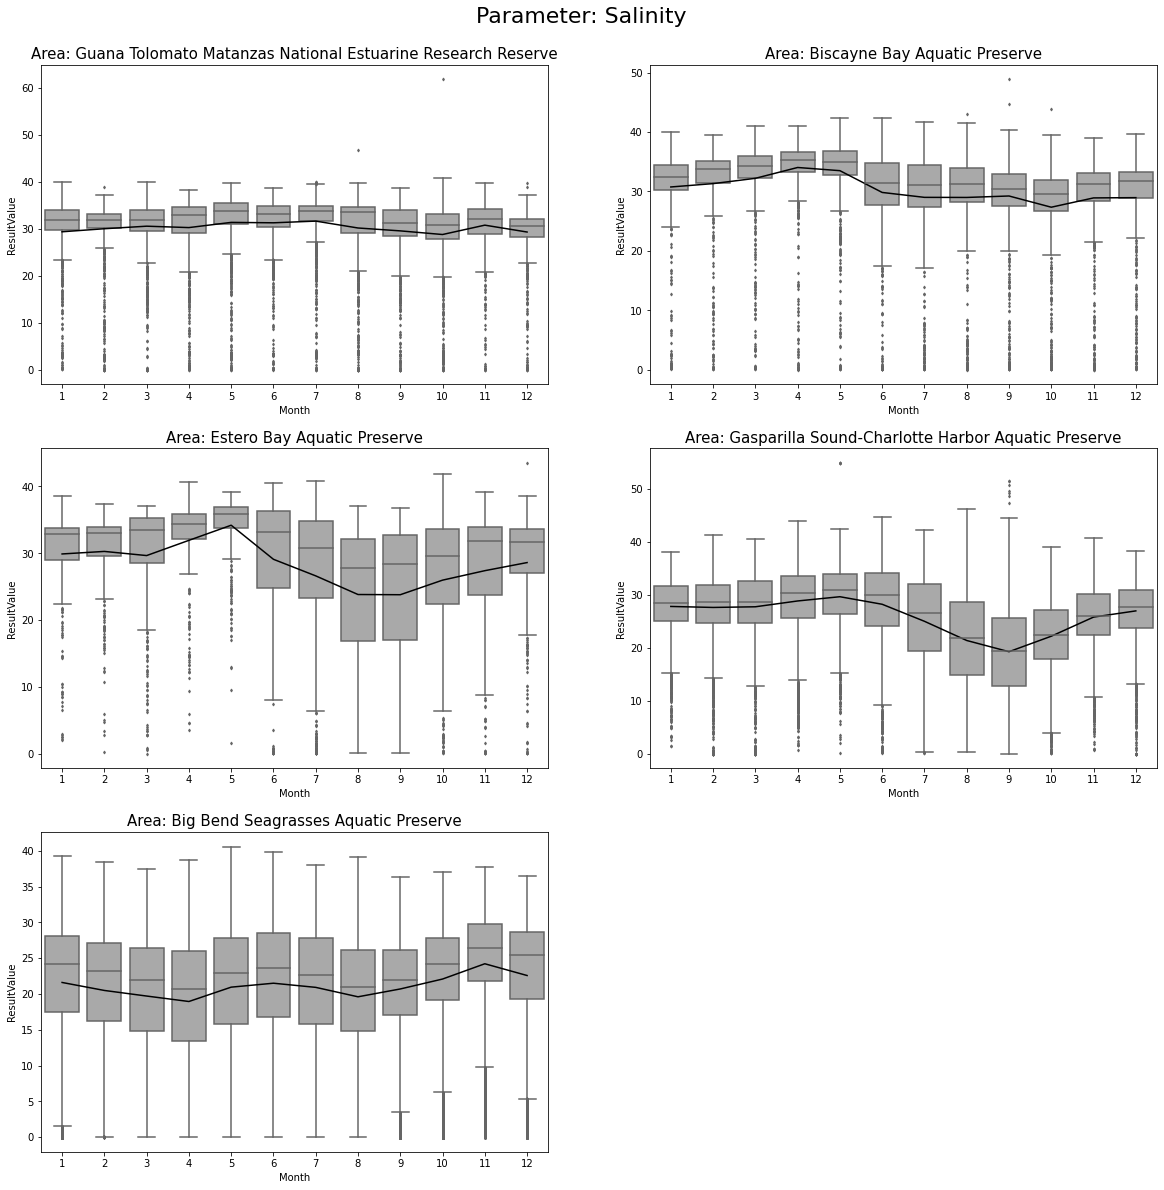

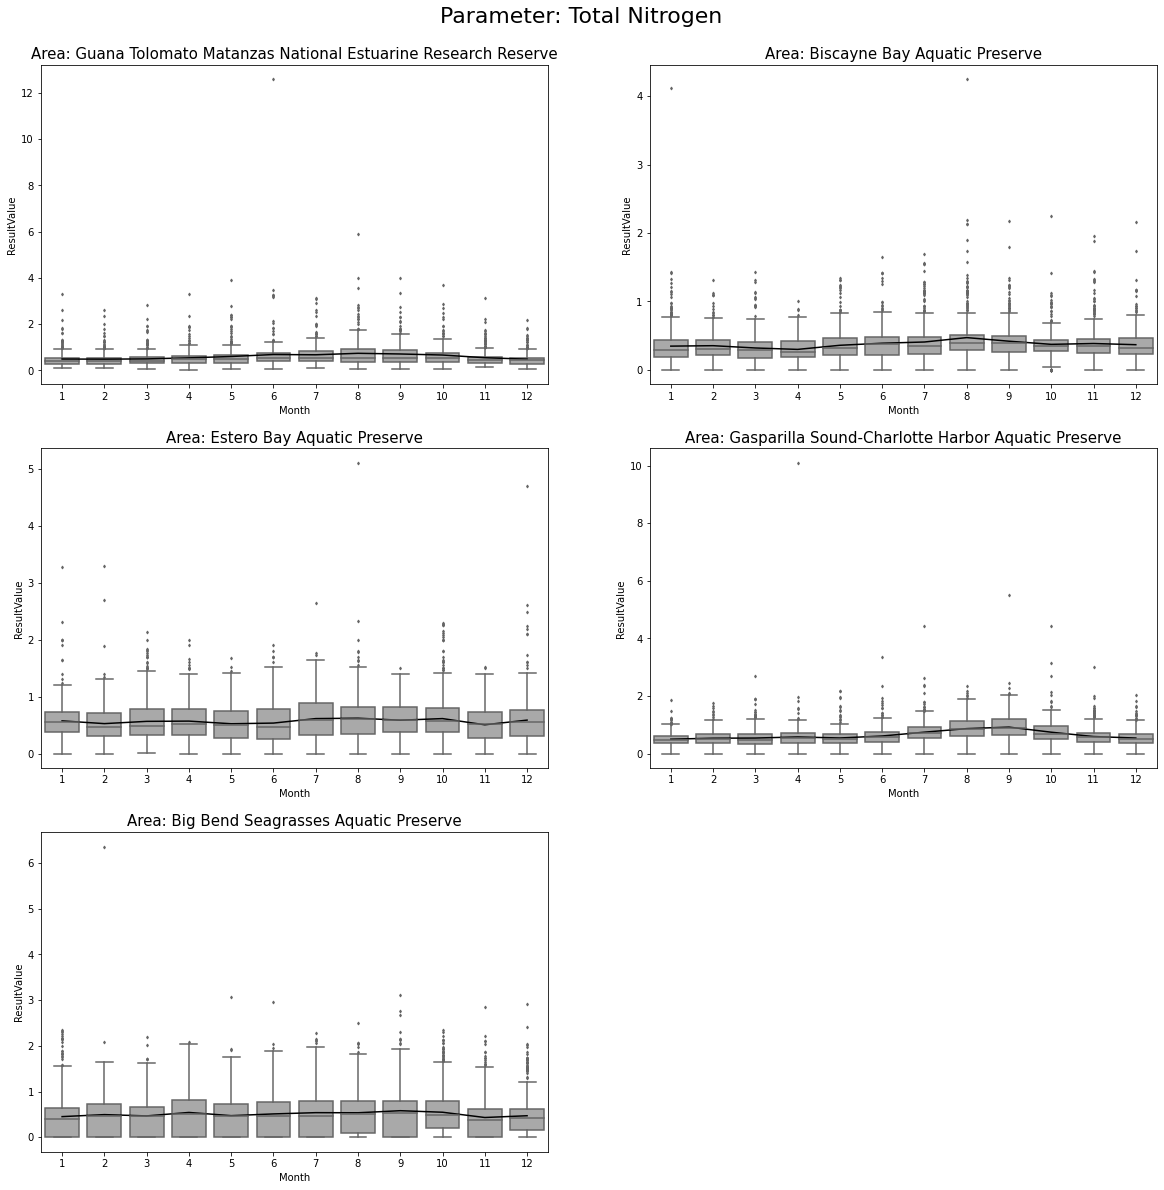

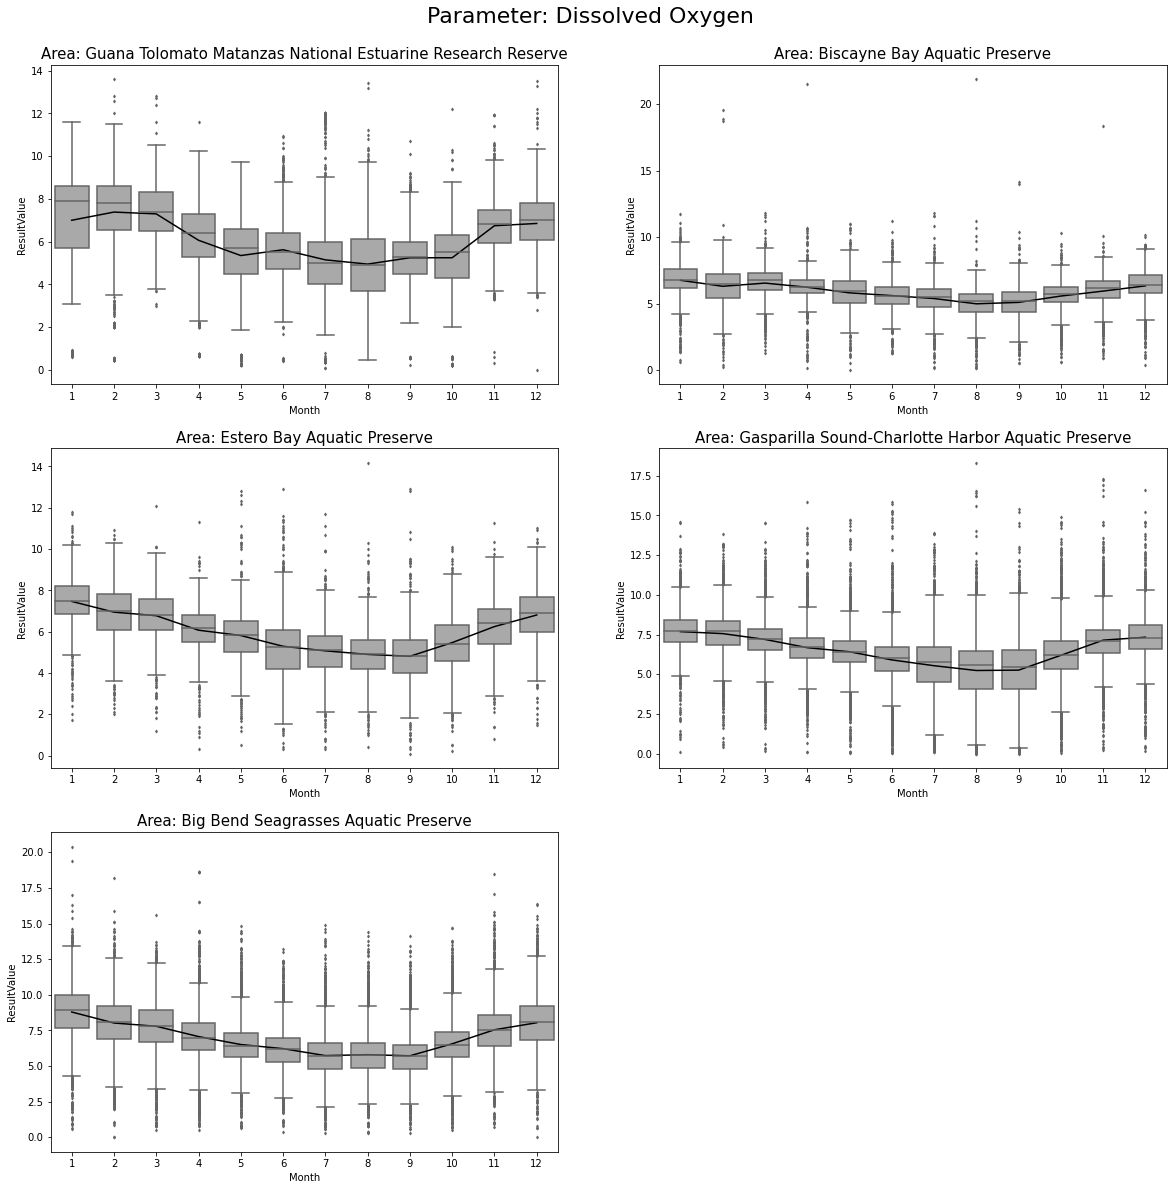

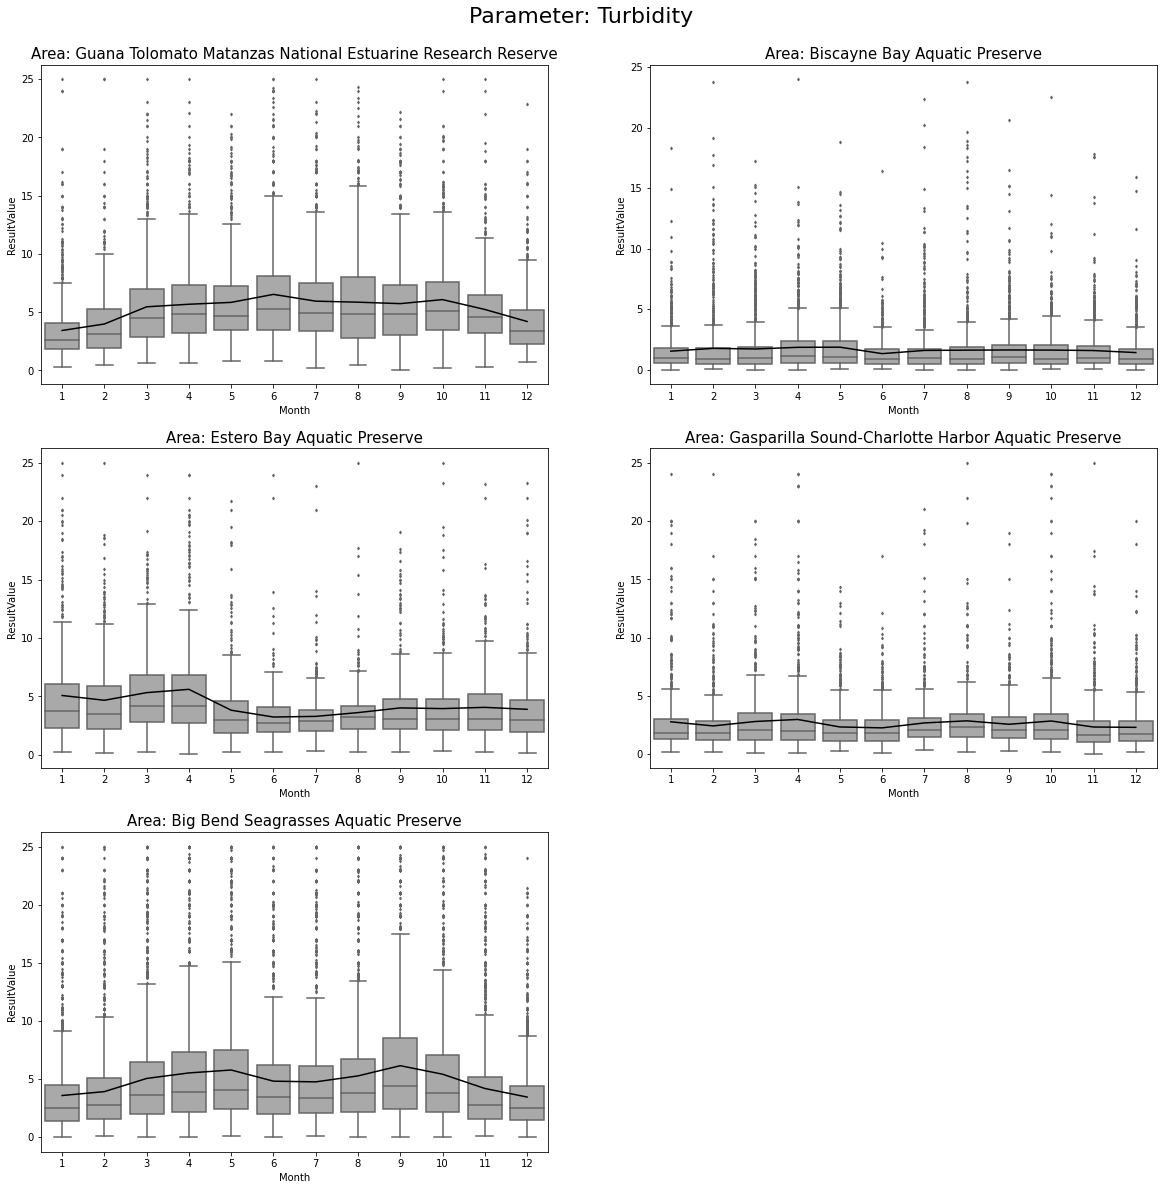

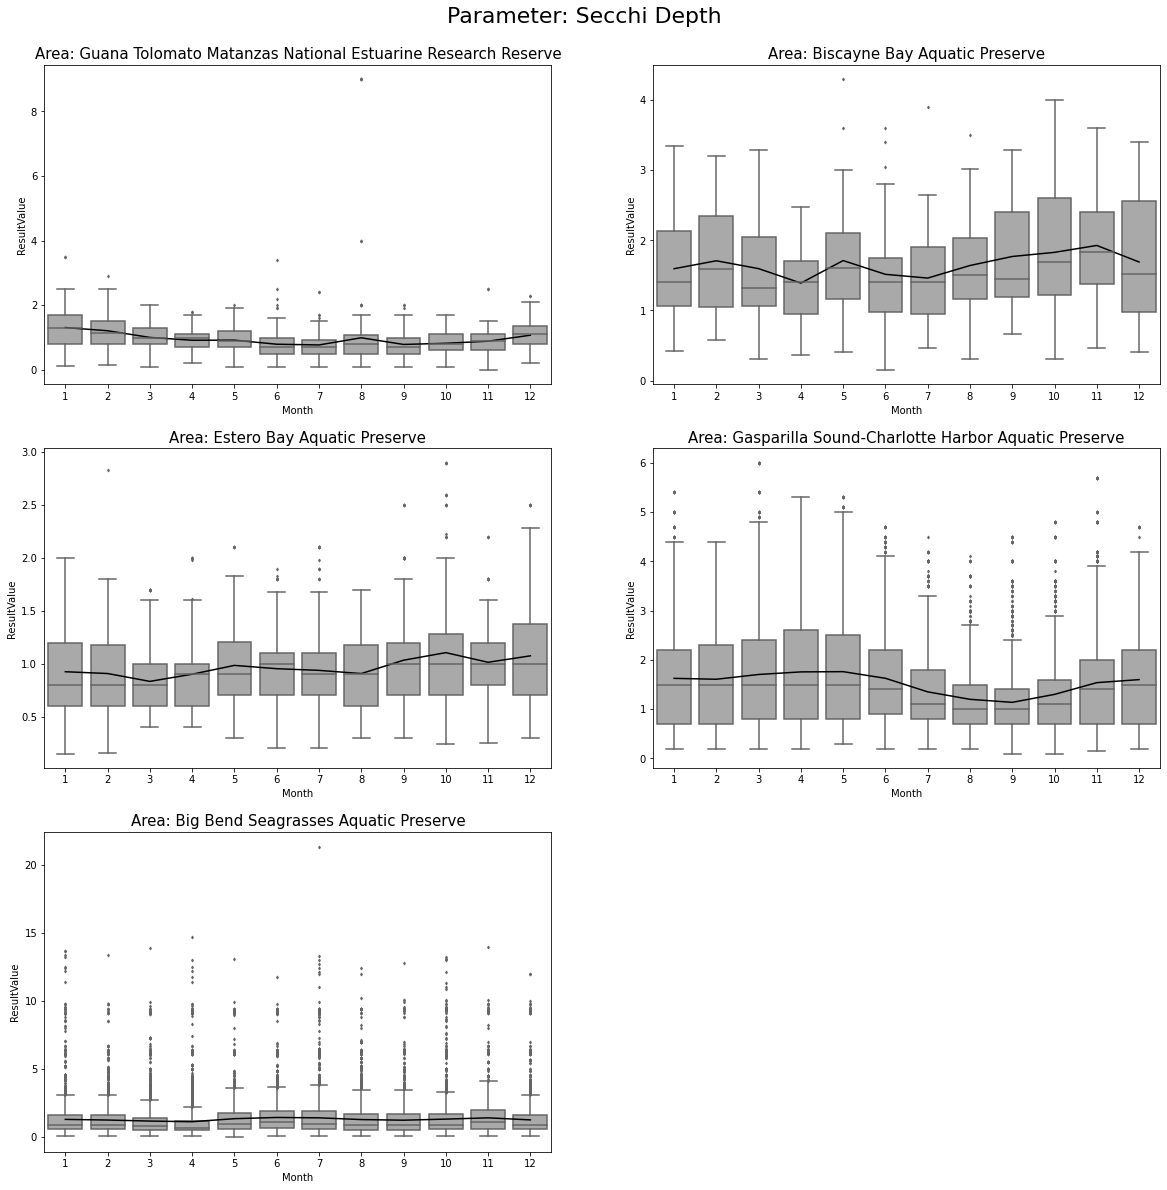

In [419]:
import seaborn as sns
# Group the data by each month
df3 = df2.groupby(["Month","ManagedAreaName","ParameterName"])["ResultValue"].agg([
    "count","max","min","mean","std"]).reset_index()


for para in listPara:
    fig = plt.figure()
    plt.suptitle("Parameter: {}".format(para), fontsize = 22, y = 0.92)
    i=0
    for area in listArea:
        df4 = df2[(df2["ManagedAreaName"]==area)&(df2["ParameterName"]==para)]
        df3_slct = df3[(df3["ManagedAreaName"]==area)&(df3["ParameterName"]==para)]

        ax = fig.add_subplot(3,2,i+1)

        sns.boxplot(x=df4["Month"], y=df4["ResultValue"],orient='v',color='darkgray',fliersize=2,ax = ax)
        sns.lineplot(x=df3_slct["Month"]-1, y=df3_slct["mean"],color='black',ax=ax)
        ax.set_title("Area: {}".format(area), size=15) # Title
        i = i+1

## 3. Fixed and random sampling locations

This step is to calculate the sample location of Salinity in five areas and to calculate whether they are fixed points or random points.


### 3.1 Distribution of repeatitive samples at unique locations
First, aggregate the data by location and parameter name.

In [332]:
plt.rcParams['figure.figsize'] = [16, 8]

dfLoc  = df2.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("count").reset_index()

dfLoc = dfLoc.rename(columns={"ResultValue": "samples"})

dfLoc.loc[dfLoc["samples"] == 1,['sample_type']] ='Random Point'
dfLoc.loc[dfLoc["samples"] > 1,['sample_type']] ='Fixed Point'

Plot histograms of samples at unique positions.

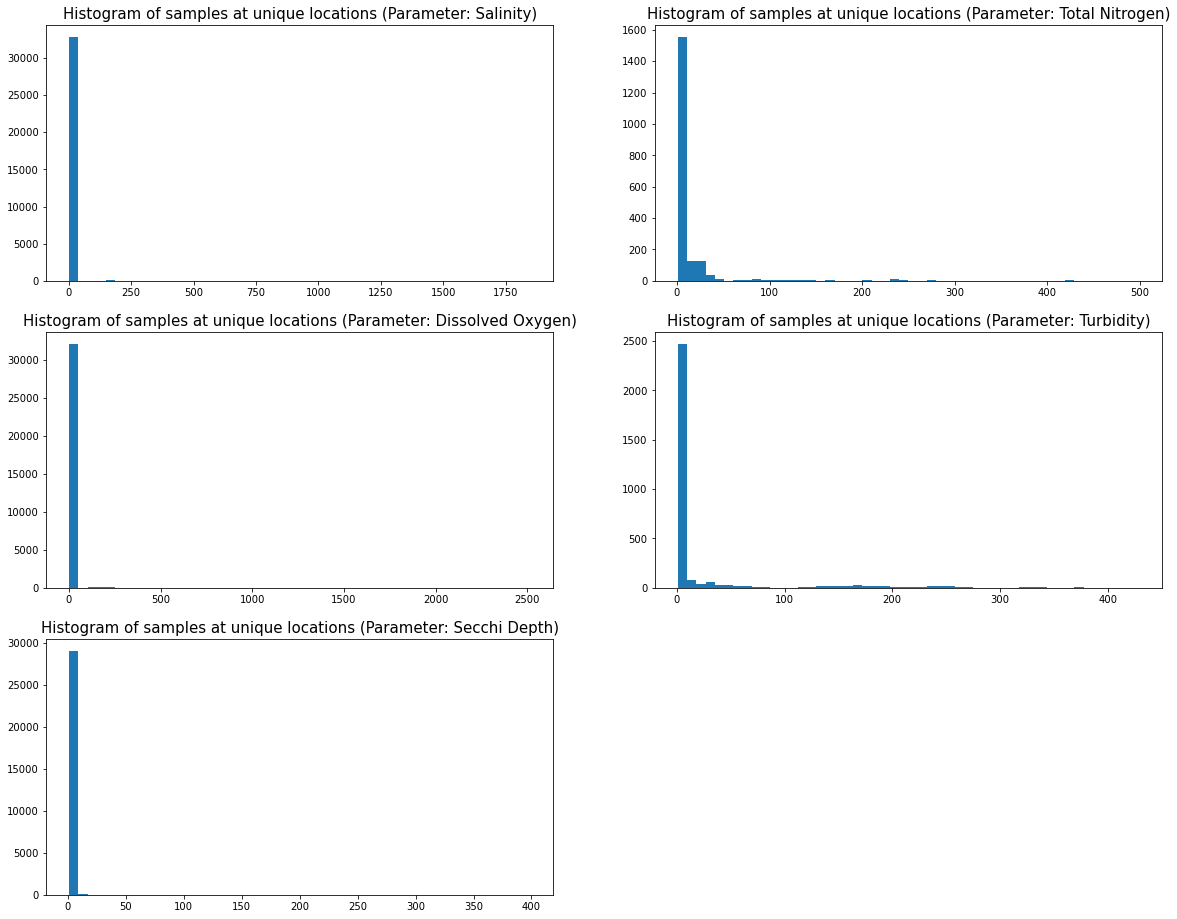

In [334]:
plt.rcParams['figure.figsize'] = [20, 16]

i = 0

fig = plt.figure()
for para in listPara:
    dfNew = dfLoc[dfLoc['ParameterName']==para]
    ax = fig.add_subplot(3,2,i+1)
    ax.set_title("Histogram of samples at unique locations (Parameter: {})".format(para), size=15) # Title  
    ax.hist(dfNew["samples"],bins=50)

    i=i+1

### 3.2 Proportions of random  sampling (1 sample) and fixed sampling (>1 samples) locations 

Plot pie charts of fixed samples and random samples

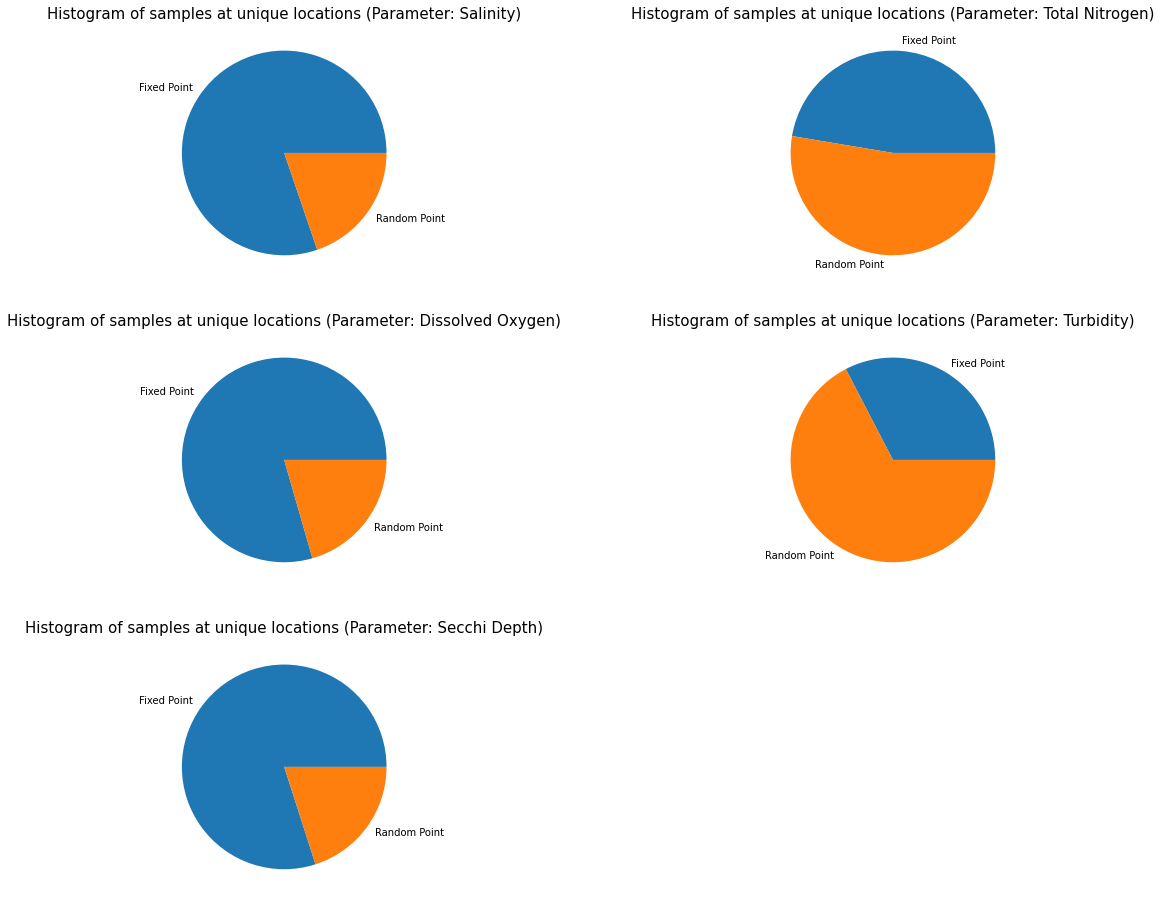

In [335]:
plt.rcParams['figure.figsize'] = [20, 16]

i = 0

fig = plt.figure()

for para in listPara:
    dfNew = dfLoc[dfLoc['ParameterName']==para]
    dfNew_agg = dfNew.groupby(['sample_type'])['samples'].agg("count").reset_index()
    ax = fig.add_subplot(3,2,i+1)
    ax.set_title("Random and fixed samples at unique locations (Parameter: {})".format(para), size=15) # Title  
    ax.pie(x = dfNew_agg["samples"],labels = dfNew_agg["sample_type"])

    i=i+1

Create bar chart to show ratios of fixed sampling locations in five managed areas

<function matplotlib.pyplot.show(close=None, block=None)>

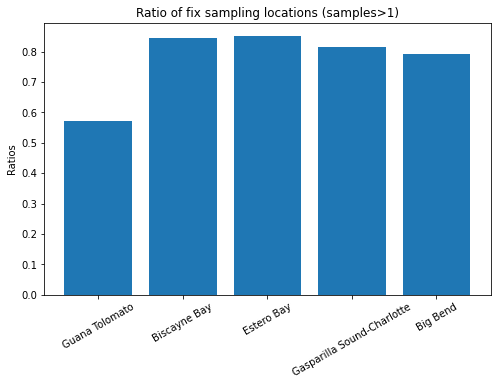

In [359]:
# This step is to calculate the ratios of fix points to total points in five areas.
ls_ratio = []
listArea_short = [] 

for area in listArea:
    gdfLocPara = dfLoc[(dfLoc['ParameterName'] == 'Salinity')&(dfLoc['ManagedAreaName'] == area)]
    allPoints  = gdfLocPara.shape[0]
    randPoints = gdfLocPara.loc[gdfLocPara["sample_type"]=="Fixed Point"].shape[0]
    ratio      = round(randPoints/allPoints,4)
    ls_ratio.append(ratio)
    listArea_short.append(area.split(' ')[0] + " "+ area.split(' ')[1])


fig = plt.figure(figsize = (8, 5))
plt.bar(listArea_short,ls_ratio)
plt.title("Ratio of fix sampling locations (samples>1)")
plt.xticks(rotation=30)
plt.ylabel("Ratios")

plt.show

### 3.3 Spatial distribution of random and fixed sampling locations

Convert sampling points of salinity to GeoDataFrame

In [336]:
# Group data by location, parametername and managed area name
gdfLoc = gpd.GeoDataFrame(dfLoc, geometry = gpd.points_from_xy(dfLoc.Longitude_DD, dfLoc.Latitude_DD), crs="EPSG:4326")

Plot fixed and random sampling location in a managed aera

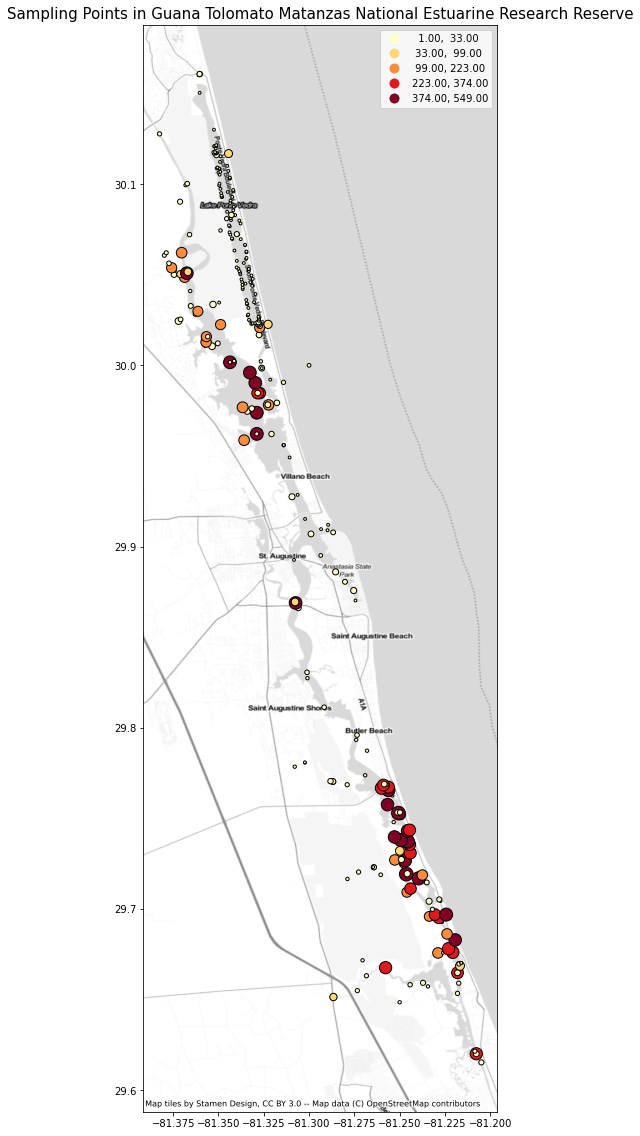

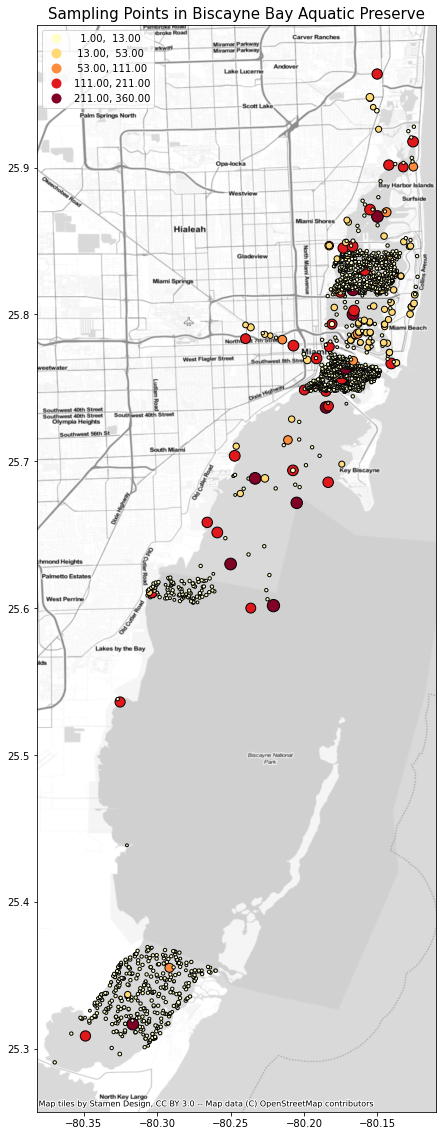

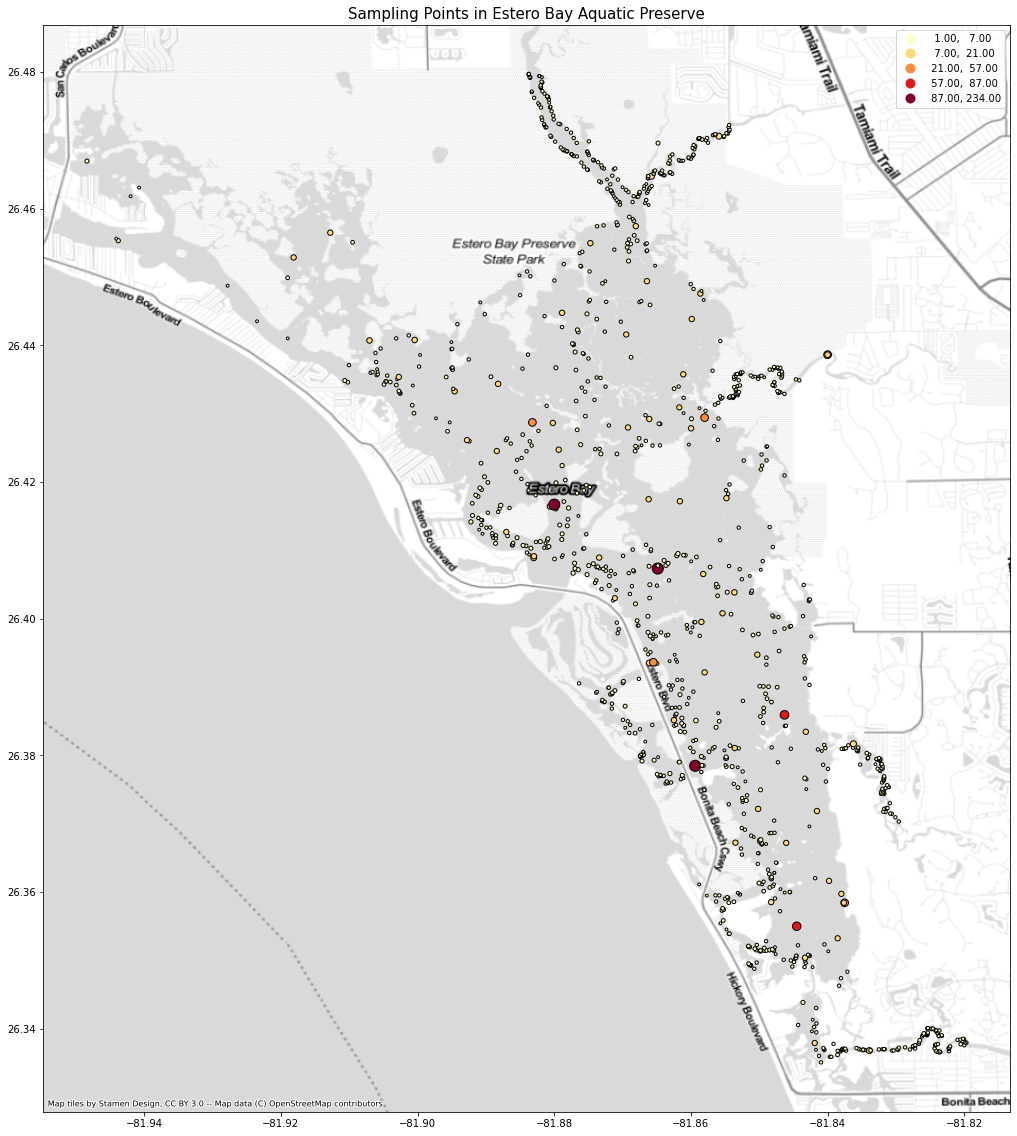

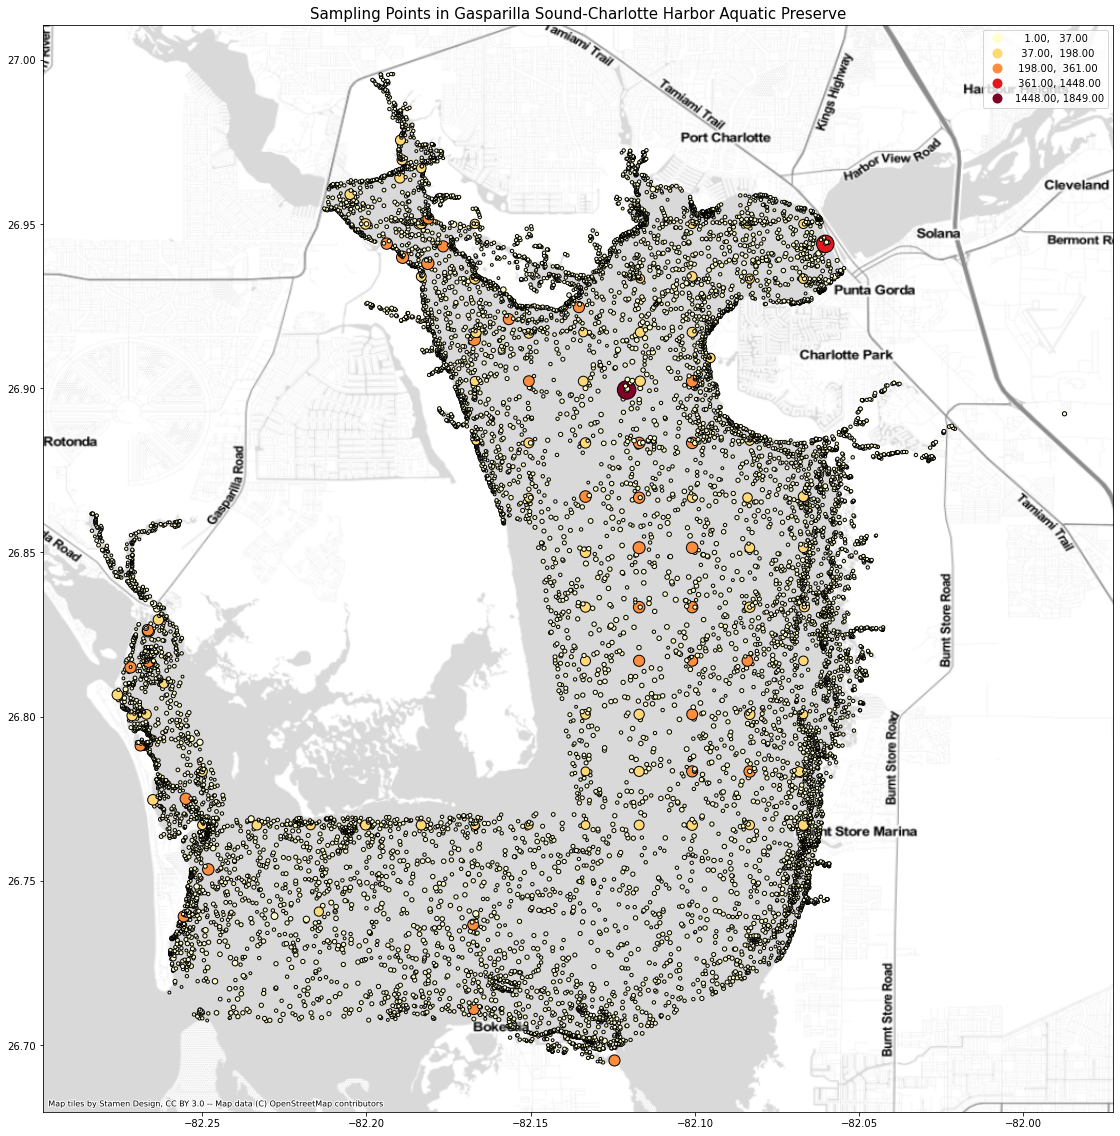

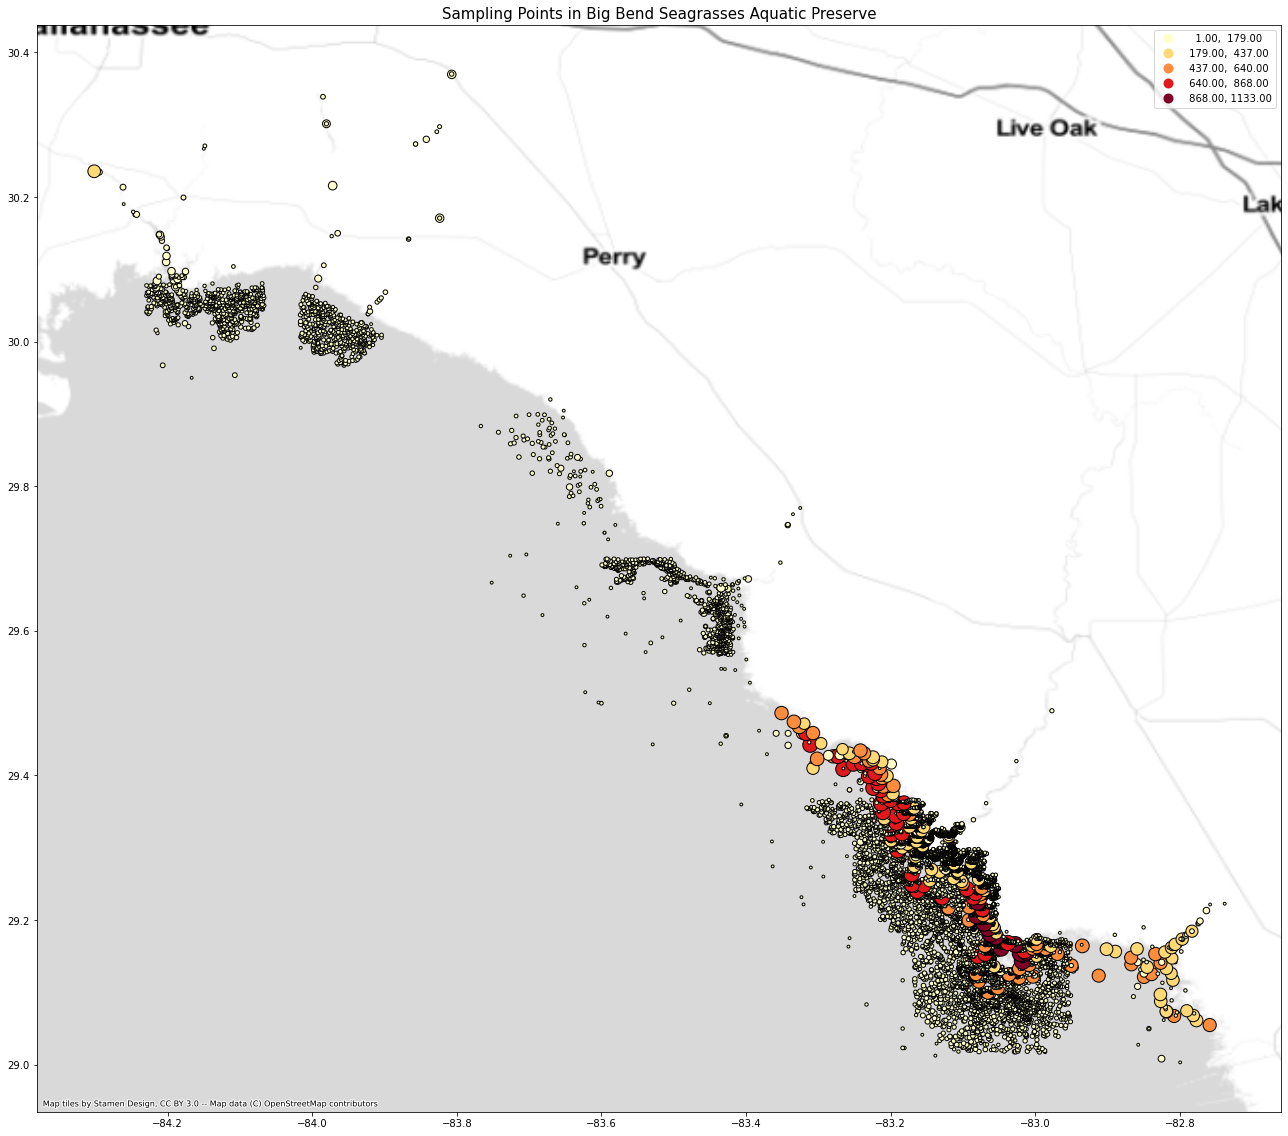

In [477]:
import matplotlib.colors

plt.rcParams['figure.figsize'] = [30, 20]

gdfLocPara = gdfLoc[gdfLoc['ParameterName']=='Salinity']

#cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue","orange"])

# This step is to depict the figure about fixed points and random points in each area.
for area in listArea:
    areaPoint = gdfLocPara[gdfLocPara["ManagedAreaName"] == area]
    #ax = areaPoint.plot(marker="o",facecolors='none', edgecolors='r',markersize=areaPoint['samples'])
    ax = areaPoint.plot(column ='samples',k=5,cmap="YlOrRd", scheme = 'NaturalBreaks',legend=True,
                       marker="o",facecolors='none', edgecolors='black',markersize=areaPoint['samples']**(1/2)*8)
    ax.set_title("Sampling Points in "+str(area),size=15)
    cx.add_basemap(ax,source=cx.providers.Stamen.TonerLite,crs=gdf_Salinity.crs)
    #cx.add_basemap(ax,source=cx.providers.CartoDB.Positron,crs=gdf_Salinity.crs)